In [1]:
import pandas as pd
import os

In [2]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_mels.pkl')

In [3]:
import torch

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

In [5]:
from model_common import *

In [6]:
class MelMatrixDataset(AbsDataset):
    def __init__(self, labels, mels):
        super().__init__()
        self.labels = labels
        self.mels = mels

    def __get__(self,index):
      if self.mels[index].shape[1] < 9601:
        self.mels[index] = torch.hstack((self.mels[index],torch.zeros(40,9601-self.mels[index].shape[1])))
      return self.mels[index].reshape((1,)+self.mels[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mel_spec'].iloc[x] for x in train_ids]
      test_vals = [data['mel_spec'].iloc[x] for x in test_ids]
      train_data = MelMatrixDataset(train_lbls, train_vals)
      test_data = MelMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [7]:
gpu, cpu =get_devices()
import warnings
warnings.filterwarnings('ignore')

In [62]:
class MelRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten()
        )
        self.final = nn.Sequential(nn.Linear(48000, 1000),nn.ReLU(), nn.Linear(1000, n_labels))
        
    def forward(self,x):
        return self.final(self.cnn(x))
    
    def __del__(self):
        self.to(cpu)

FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.52056673 12.65555556]
Epoch 1/25 : Training Loss: 10.267 / Validation Loss : 2.275 [Time Taken : 3.392755 seconds]
Epoch 2/25 : Training Loss: 1.023 / Validation Loss : 1.078 [Time Taken : 3.207049 seconds]
Epoch 3/25 : Training Loss: 0.294 / Validation Loss : 1.849 [Time Taken : 2.706872 seconds]
Epoch 4/25 : Training Loss: 0.116 / Validation Loss : 1.450 [Time Taken : 2.66221 seconds]
Epoch 5/25 : Training Loss: 0.108 / Validation Loss : 1.338 [Time Taken : 2.676107 seconds]
Epoch 6/25 : Training Loss: 0.091 / Validation Loss : 1.601 [Time Taken : 2.680732 seconds]
Epoch 7/25 : Training Loss: 0.069 / Validation Loss : 2.230 [Time Taken : 2.667127 seconds]
Epoch 8/25 : Training Loss: 0.050 / Validation Loss : 2.713 [Time Taken : 2.659201 seconds]
Epoch 9/25 : Training Loss: 0.041 / Validation Loss : 2.567 [Time Taken : 2.676701 seconds]
Epoch 10/25 : Training Loss: 0.036 / Validation Loss : 2.616 [Time Taken : 2.669949 sec

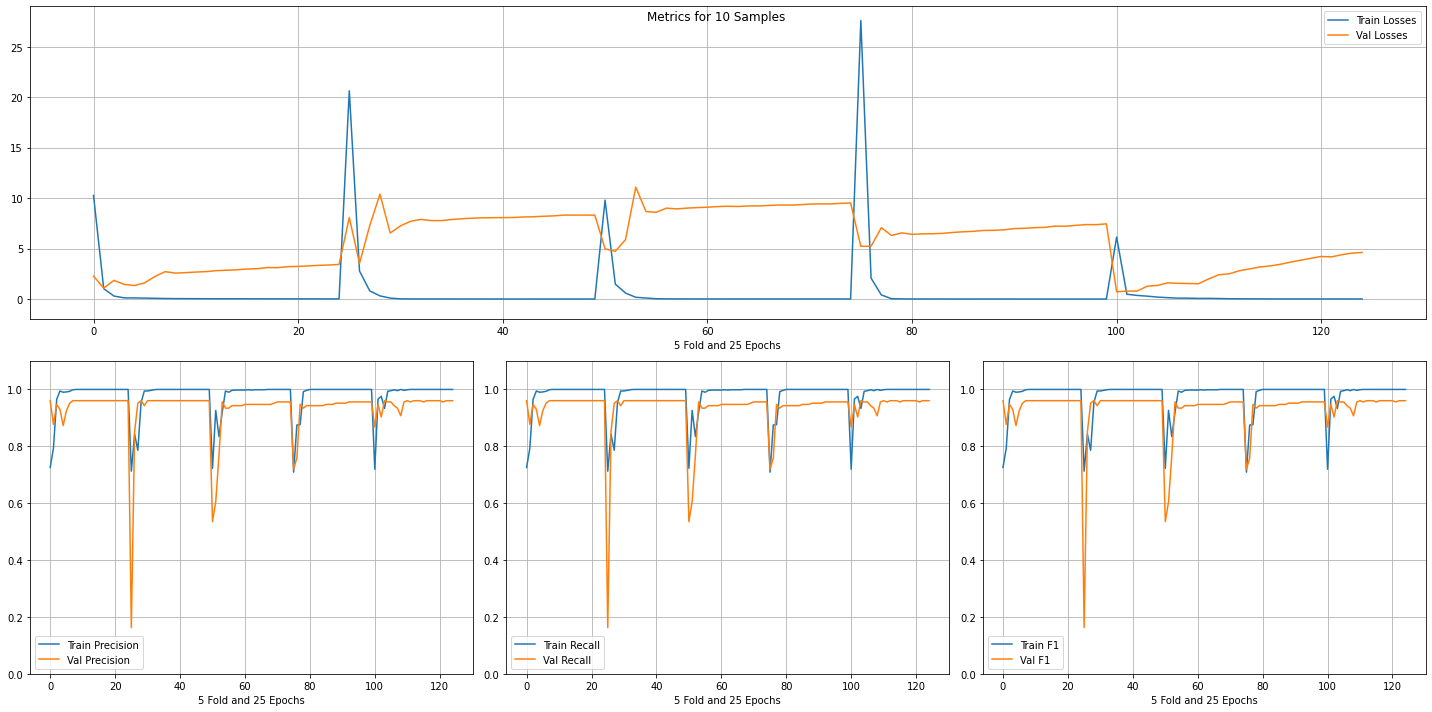

In [64]:
tmp = train_model(ndata, MelMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : False,
                                   'lr' : 1e-4,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : '10 Samples',
                                   'plot' : True,
                                   'epochs' : 25,
                                   'model' : MelRaga,
                                   'feature' : 'mel_spec',
                                   'target' : 'RagamCode'})

In [65]:
torch.cuda.empty_cache()
!nvidia-smi

Mon Nov 22 18:15:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    34W / 250W |   2417MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [67]:
pindex.shape[0]

45

In [69]:
def ovr_train_model(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, target='RagamCode', feature='mfcc', lr=5e-3,
                    lstm=False, dropout=0.1, epochs=15, n_folds=2):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: 
      lbl = lbl_encoder.inverse_transform([i])
      print(f'Training for {lbl} with {nsamples} positive samples')
    else:
      lbl = i
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    pindex = ndata[ndata[target]==1].index
    nindex = ndata[ndata[target]==0].index
    index = np.random.choice(pindex,pindex.shape[0]).tolist() + np.random.choice(nindex,3*pindex.shape[0]).tolist()
    tdata = ndata.loc[index]
    
    results[i] = train_model(tdata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : lstm,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : n_folds,
                                   'balance_classes' : True,
                                   'dropout' : dropout,
                                   'title' : f'{title} - {lbl}',
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['ఆహిరి'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 144/36
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 8.274 / Validation Loss : 4.409 [Time Taken : 1.030233 seconds]
Epoch 2/15 : Training Loss: 6.242 / Validation Loss : 4.394 [Time Taken : 0.993212 seconds]
Epoch 3/15 : Training Loss: 5.606 / Validation Loss : 1.659 [Time Taken : 0.994689 seconds]
Epoch 4/15 : Training Loss: 1.774 / Validation Loss : 0.908 [Time Taken : 1.009784 seconds]
Epoch 5/15 : Training Loss: 0.945 / Validation Loss : 1.482 [Time Taken : 0.462437 seconds]
Epoch 6/15 : Training Loss: 0.039 / Validation Loss : 0.382 [Time Taken : 0.990793 seconds]
Epoch 7/15 : Training Loss: 0.128 / Validation Loss : 0.542 [Time Taken : 0.471939 seconds]
Epoch 8/15 : Training Loss: 0.246 / Validation Loss : 0.472 [Time Taken : 0.447703 seconds]
Epoch 9/15 : Training Loss: 0.133 / Validation Loss : 0.350 [Time Taken : 0.990573 seconds]
Epoch 10/15 : Training Loss: 0.056 / Valid

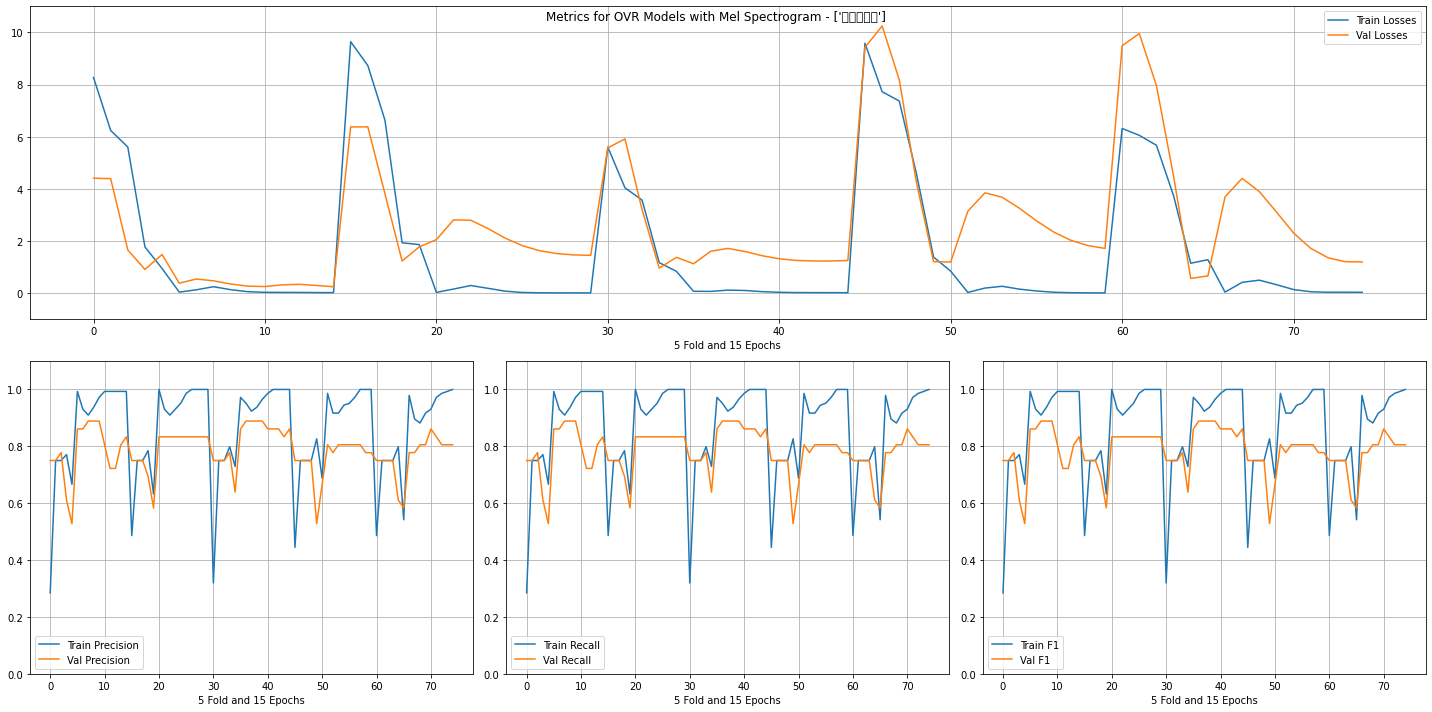

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.923611       0.888889  ...      0.115835           1.716217
7   0.909722       0.888889  ...      0.246049           0.471956
6   0.951389       0.888889  ...      0.066737           1.605274
8   0.937500       0.888889  ...      0.101688           1.597673
9   0.972222       0.888889  ...      0.055504           0.267621
..       ...            ...  ...           ...                ...
3   0.770833       0.611111  ...      1.773628           0.908444
4   0.631944       0.583333  ...      1.862186           1.774860
5   0.541667       0.583333  ...      1.282787           0.660225
4   0.826389       0.527778  ...      1.384609           1.205586
4   0.666667       0.527778  ...      0.944905           1.481953

[75 rows x 8 columns]
Training for ['కన్నడగౌళ'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 48/12
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 3.368 / Validation Loss :

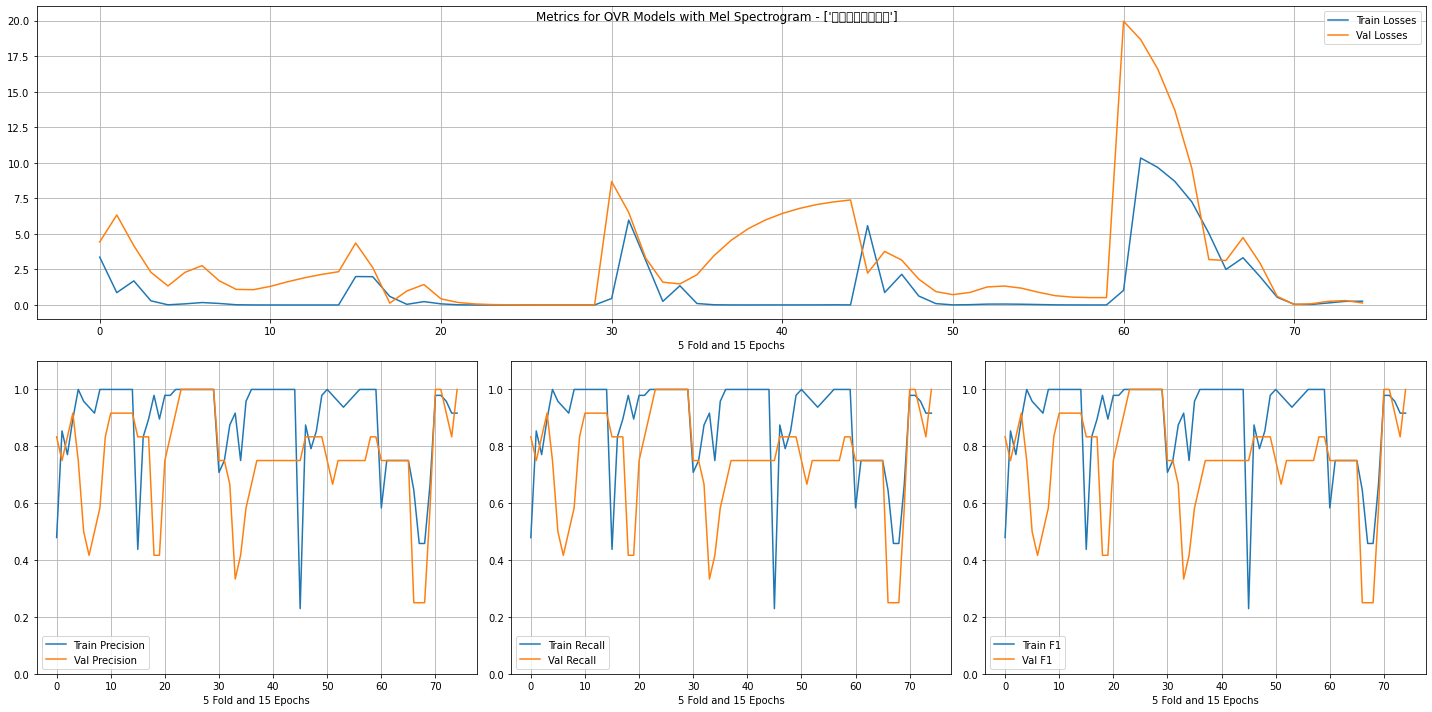

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.916667       1.000000  ...      0.266352           0.138968
10  1.000000       1.000000  ...      0.000005           0.005813
8   1.000000       1.000000  ...      0.000089           0.027083
11  1.000000       1.000000  ...      0.000002           0.003355
12  1.000000       1.000000  ...      0.000001           0.002152
..       ...            ...  ...           ...                ...
4   0.750000       0.416667  ...      1.352385           1.481513
3   0.916667       0.333333  ...      0.253647           1.604061
6   0.645833       0.250000  ...      2.498814           3.129027
7   0.458333       0.250000  ...      3.321986           4.737865
8   0.458333       0.250000  ...      1.992075           2.942242

[75 rows x 8 columns]
Training for ['కాంబోది'] with 19 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 60/16
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 12.103 / Validation Loss :

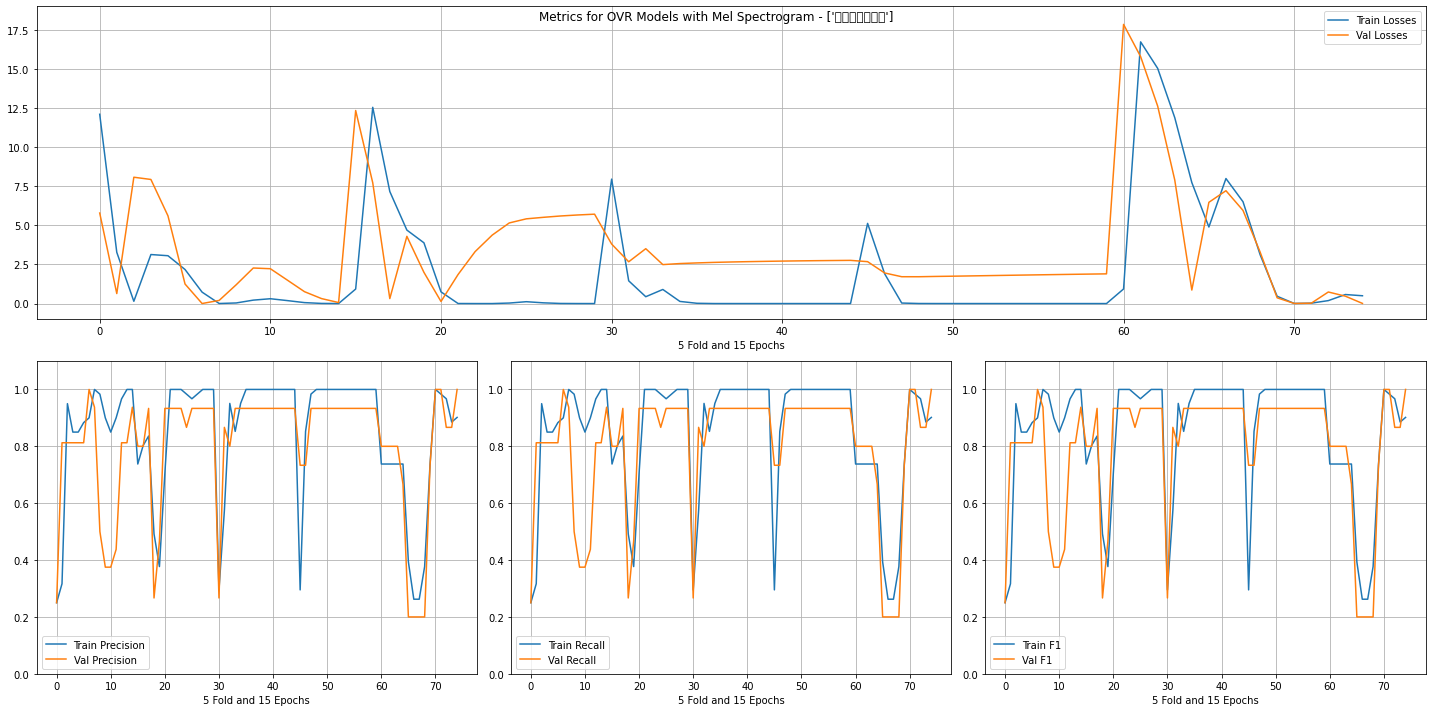

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.901639         1.0000  ...      0.499283           0.008962
11  0.983607         1.0000  ...      0.025279           0.023280
10  1.000000         1.0000  ...      0.007545           0.007566
6   0.900000         1.0000  ...      0.729855           0.002961
14  1.000000         0.9375  ...      0.002089           0.064805
..       ...            ...  ...           ...                ...
0   0.250000         0.2500  ...     12.102820           5.788855
8   0.377049         0.2000  ...      3.130901           3.298572
7   0.262295         0.2000  ...      6.509458           5.954543
5   0.393443         0.2000  ...      4.893946           6.473210
6   0.262295         0.2000  ...      7.993480           7.215214

[75 rows x 8 columns]
Training for ['గుండుక్రియ'] with 28 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 89/23
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 15.798 / Validation Los

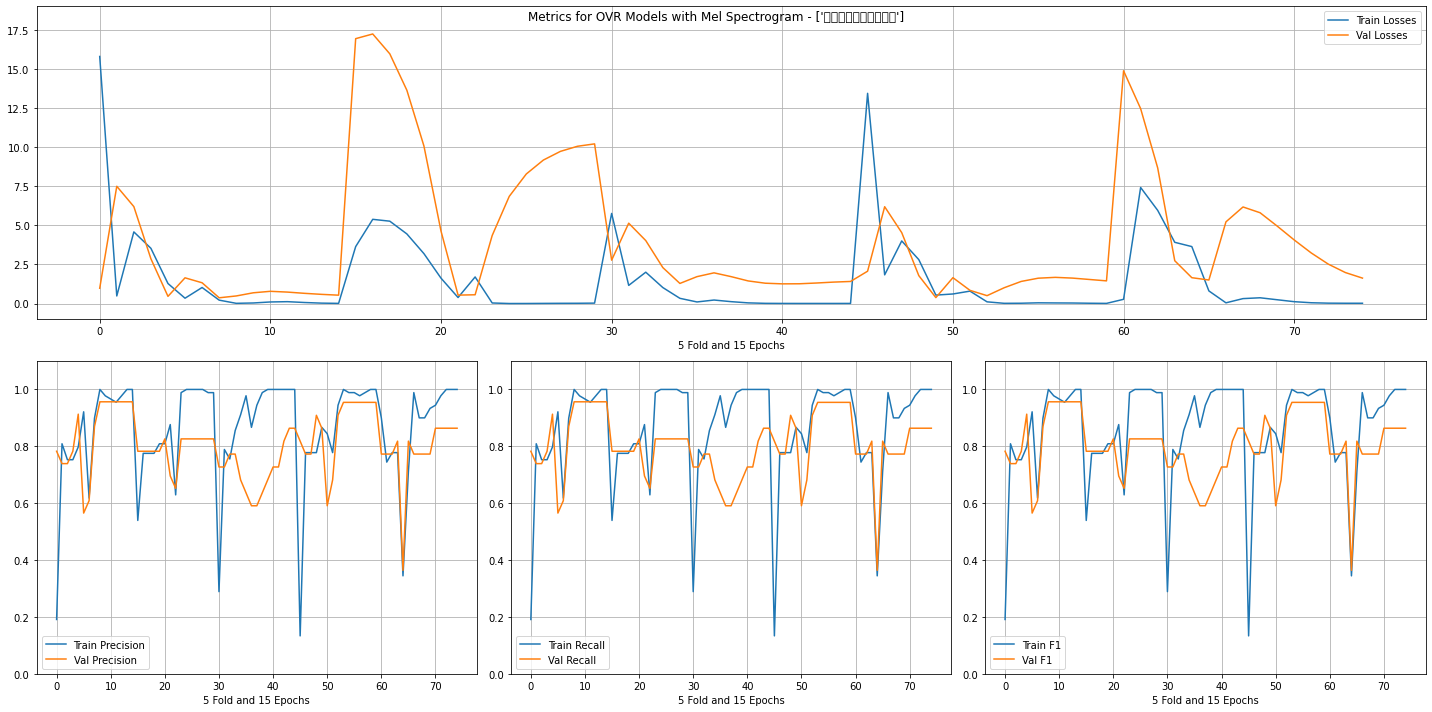

    train_f1  validation_f1  ...  train_losses  validation_losses
10  0.966292       0.956522  ...      0.101657           0.783111
11  0.955056       0.956522  ...      0.120607           0.733397
14  1.000000       0.956522  ...      0.012022           0.535951
13  1.000000       0.956522  ...      0.027195           0.588419
8   1.000000       0.956522  ...      0.015243           0.486252
..       ...            ...  ...           ...                ...
5   0.844444       0.590909  ...      0.612465           1.655332
6   0.866667       0.590909  ...      0.225475           1.963864
7   0.944444       0.590909  ...      0.121900           1.722256
5   0.921348       0.565217  ...      0.342100           1.645732
4   0.344444       0.363636  ...      3.642857           1.653942

[75 rows x 8 columns]
Training for ['గుజ్జరి'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 48/12
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 4.964 / Validation Loss : 

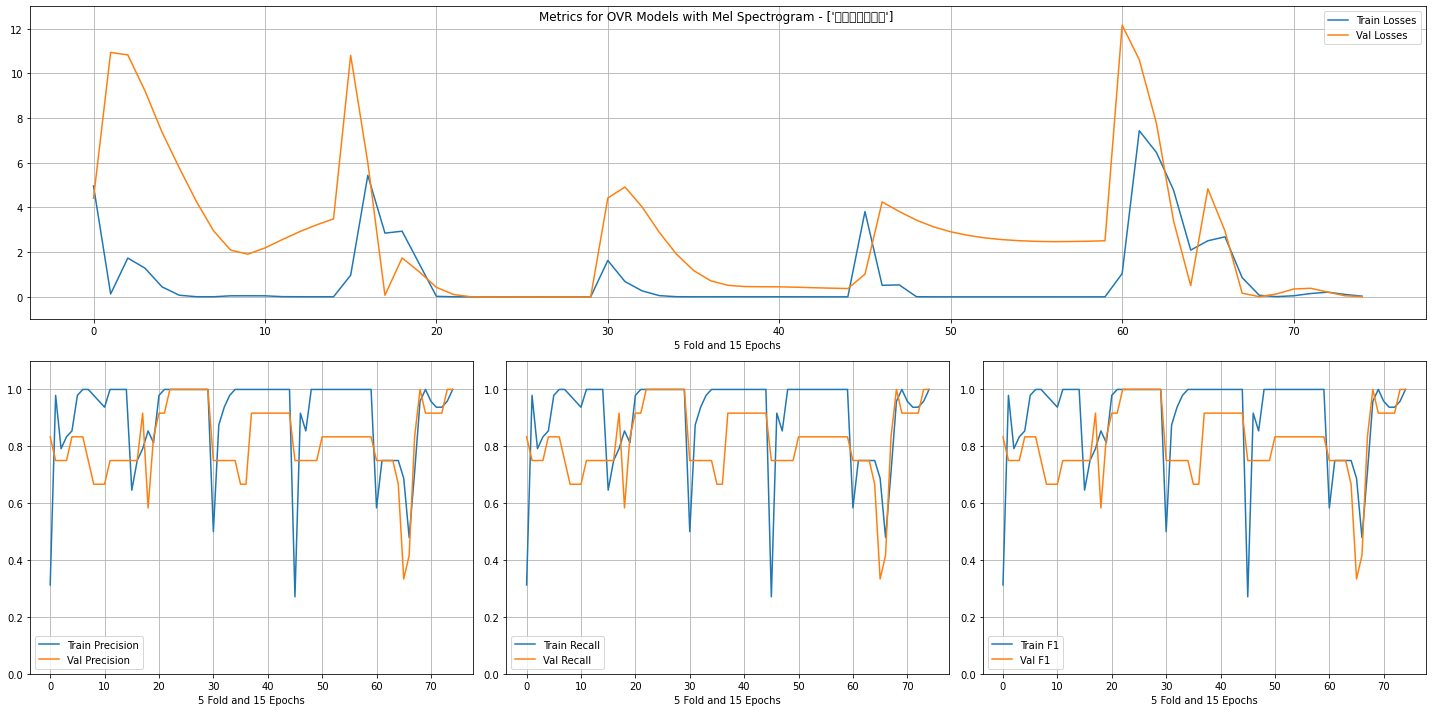

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       1.000000  ...      0.030323           0.007980
7   1.000000       1.000000  ...      0.001506           0.003396
9   1.000000       1.000000  ...      0.000922           0.000009
10  1.000000       1.000000  ...      0.002113           0.000019
11  1.000000       1.000000  ...      0.003936           0.000052
..       ...            ...  ...           ...                ...
8   0.979167       0.666667  ...      0.047115           2.092169
9   0.958333       0.666667  ...      0.048033           1.910328
3   0.854167       0.583333  ...      2.938515           1.741237
6   0.479167       0.416667  ...      2.687091           2.939825
5   0.687500       0.333333  ...      2.509989           4.835649

[75 rows x 8 columns]
Training for ['గౌళ'] with 14 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 44/12
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 1.157 / Validation Loss : 12.8

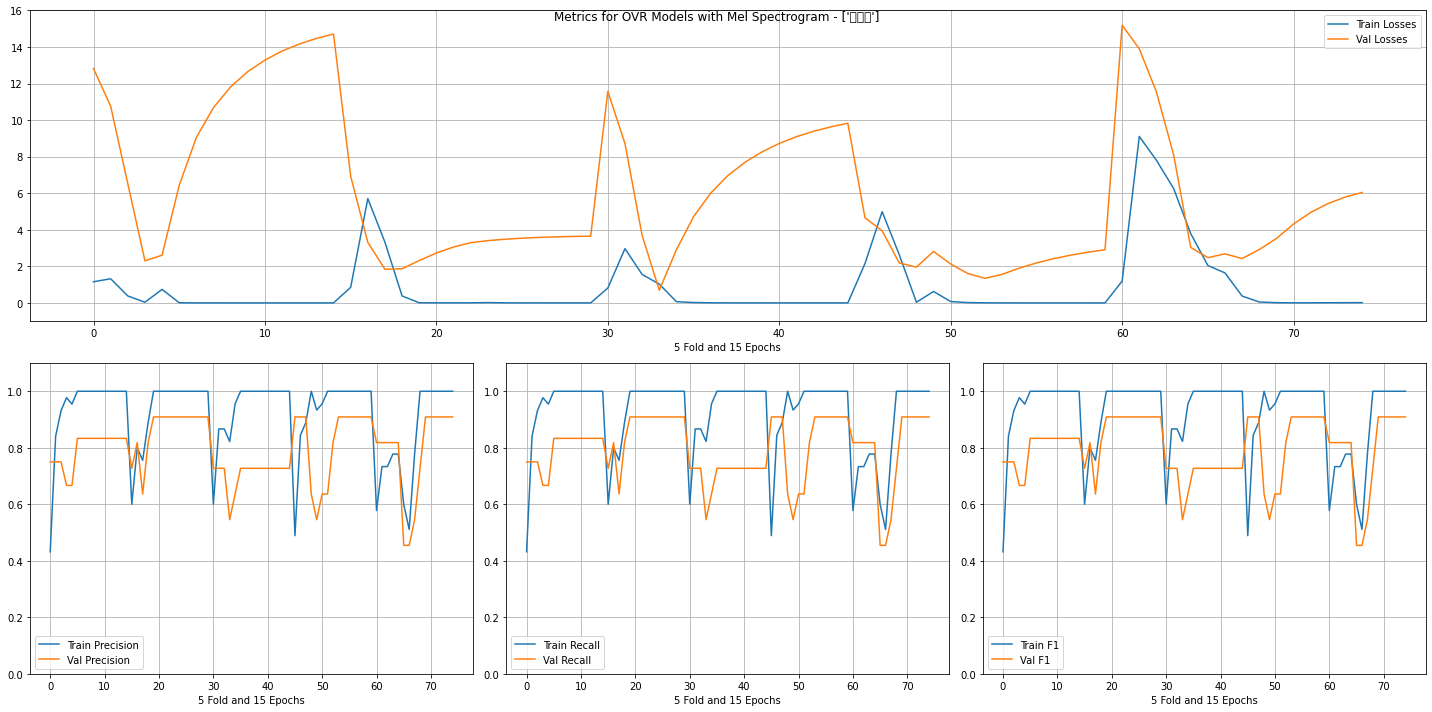

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.909091  ...      0.015207           6.041064
14  1.000000       0.909091  ...      0.001414           3.651378
0   0.488889       0.909091  ...      2.154267           4.653937
8   1.000000       0.909091  ...      0.017841           3.406772
9   1.000000       0.909091  ...      0.004574           3.482800
..       ...            ...  ...           ...                ...
7   0.777778       0.545455  ...      0.373233           2.428023
4   0.933333       0.545455  ...      0.624966           2.815796
3   0.822222       0.545455  ...      1.031620           0.693323
5   0.600000       0.454545  ...      2.046899           2.474115
6   0.511111       0.454545  ...      1.639709           2.684116

[75 rows x 8 columns]
Training for ['దేవగాంధారి'] with 35 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 112/28
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 11.420 / Validation Lo

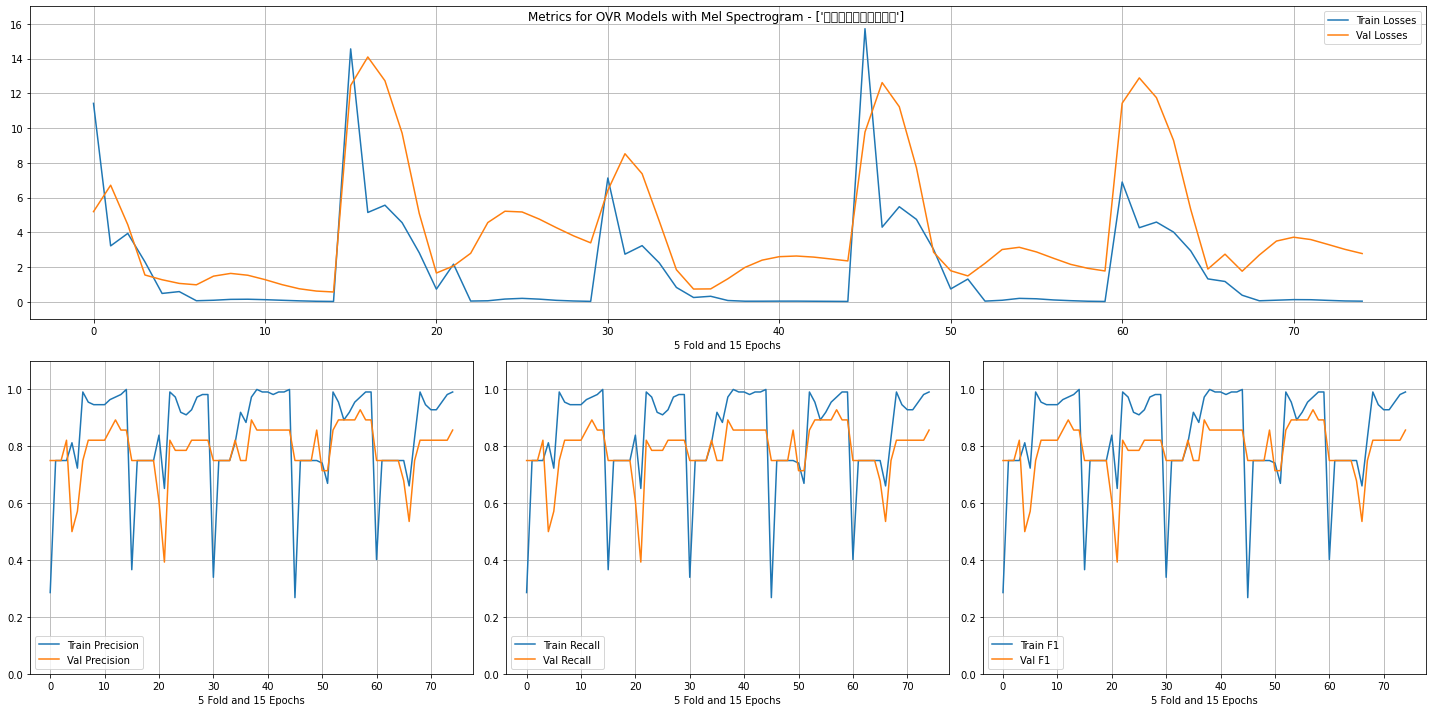

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.973214       0.928571  ...      0.066119           2.154648
7   0.973214       0.892857  ...      0.075816           1.325350
14  0.991071       0.892857  ...      0.021030           1.774624
13  0.991071       0.892857  ...      0.034154           1.927570
11  0.955357       0.892857  ...      0.107764           2.504761
..       ...            ...  ...           ...                ...
5   0.839286       0.607143  ...      0.727612           1.657228
5   0.723214       0.571429  ...      0.588487           1.059623
6   0.660714       0.535714  ...      1.170721           2.742029
4   0.812500       0.500000  ...      0.482654           1.271234
6   0.651786       0.392857  ...      2.168498           2.066112

[75 rows x 8 columns]
Training for ['దేసాక్షి'] with 29 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 92/24
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 15.230 / Validation Loss 

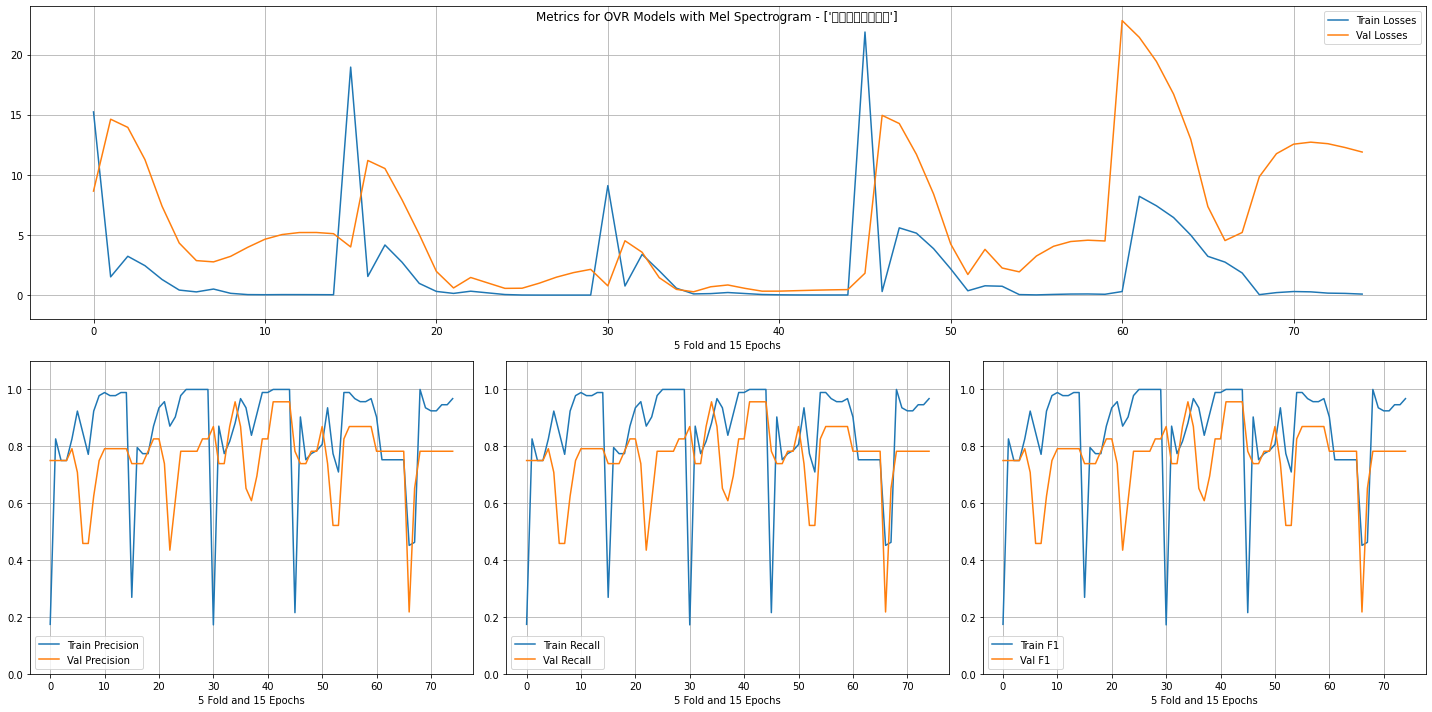

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.956522  ...      0.012876           0.460252
13  1.000000       0.956522  ...      0.011839           0.439193
12  1.000000       0.956522  ...      0.012203           0.409120
11  1.000000       0.956522  ...      0.016796           0.371407
4   0.881720       0.956522  ...      0.576023           0.479357
..       ...            ...  ...           ...                ...
7   0.774194       0.521739  ...      0.775642           3.804868
7   0.771739       0.458333  ...      0.505841           2.764795
6   0.847826       0.458333  ...      0.268338           2.870393
7   0.870968       0.434783  ...      0.327000           1.467881
6   0.451613       0.217391  ...      2.744698           4.535570

[75 rows x 8 columns]
Training for ['దేసాళం'] with 40 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 128/32
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 13.677 / Validation Loss :

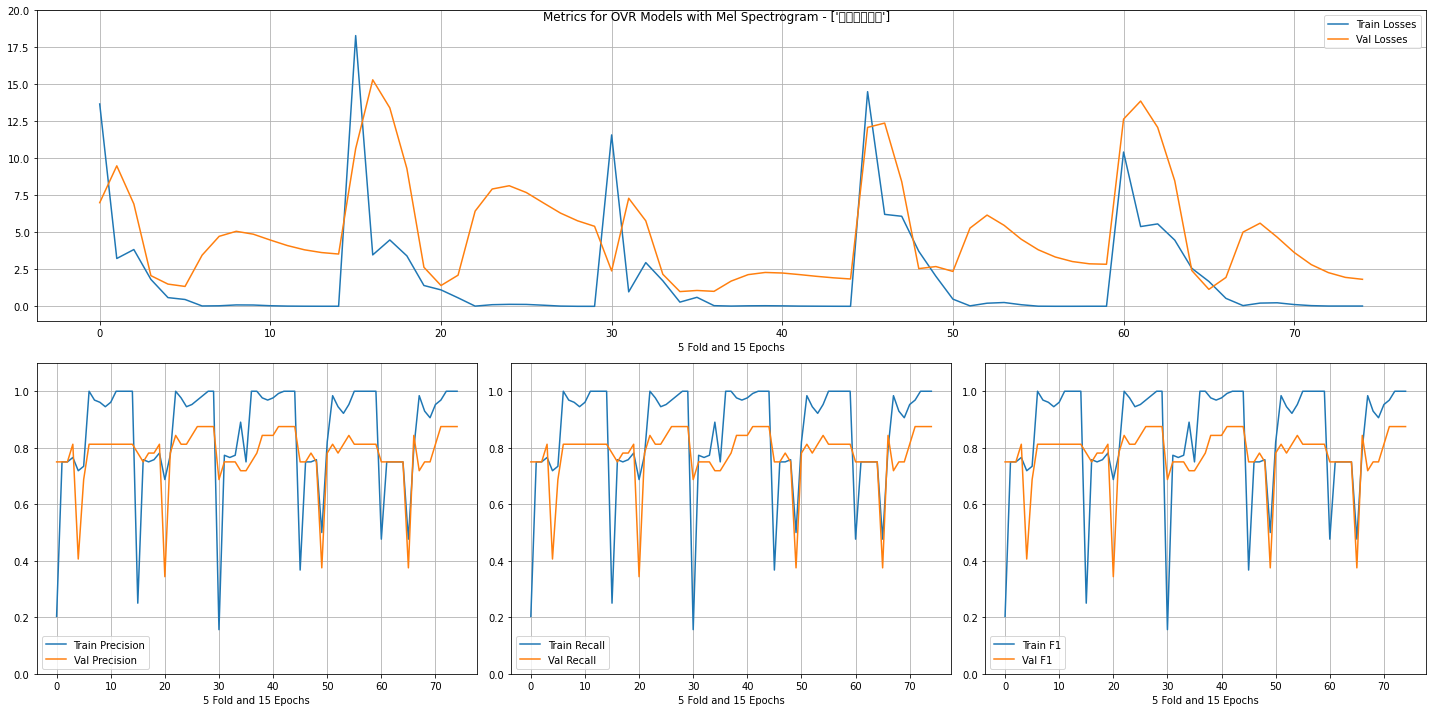

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000        0.87500  ...      0.023814           1.830567
13  1.000000        0.87500  ...      0.009137           1.931076
11  0.992188        0.87500  ...      0.020505           2.150229
14  1.000000        0.87500  ...      0.007000           1.852750
14  1.000000        0.87500  ...      0.004669           5.411888
..       ...            ...  ...           ...                ...
5   0.734375        0.68750  ...      0.467142           1.348979
4   0.718750        0.40625  ...      0.593815           1.506888
5   0.476562        0.37500  ...      1.686740           1.152046
4   0.500000        0.37500  ...      2.038048           2.692319
5   0.687500        0.34375  ...      1.115166           1.410984

[75 rows x 8 columns]
Training for ['ధన్నాసి'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 64/16
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 9.757 / Validation Loss : 

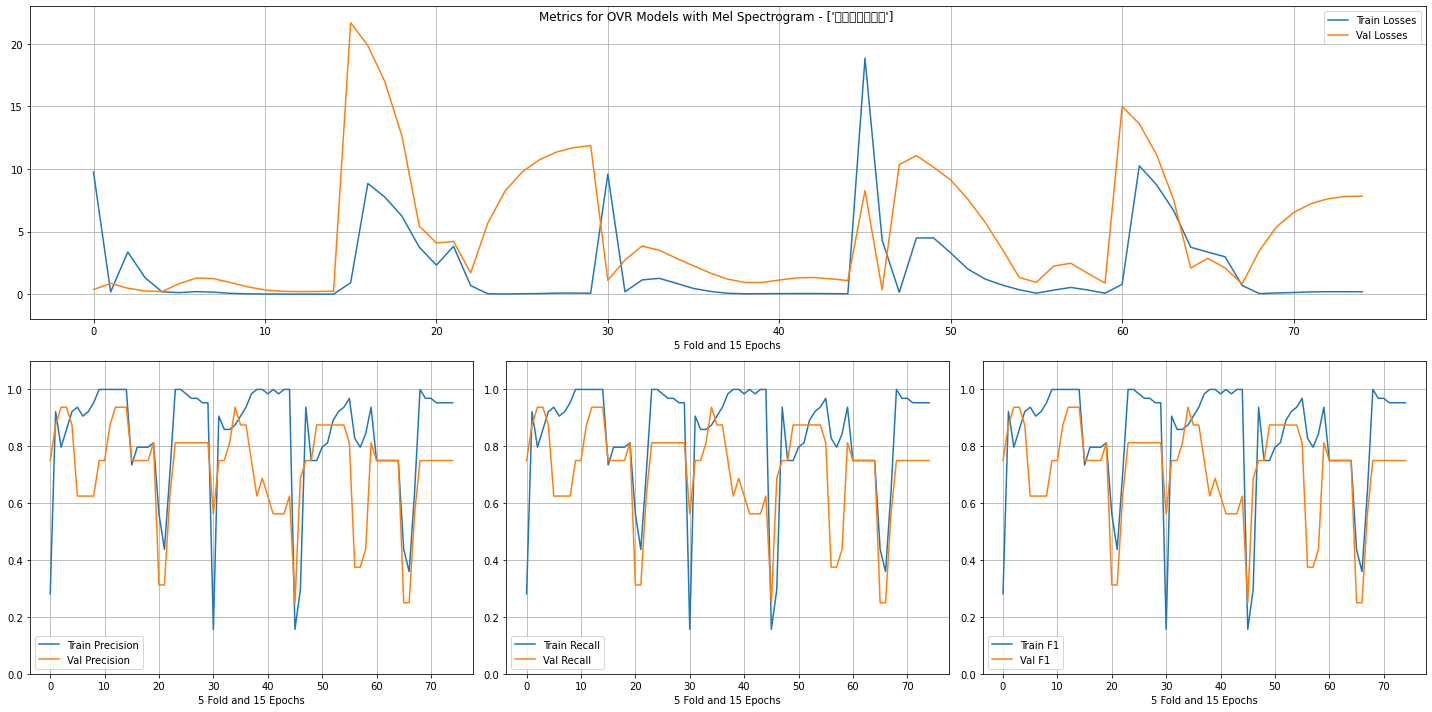

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000         0.9375  ...      0.001327           0.232039
2   0.796875         0.9375  ...      3.369603           0.476200
3   0.859375         0.9375  ...      1.329465           0.262391
4   0.875000         0.9375  ...      0.870213           2.872317
13  1.000000         0.9375  ...      0.001987           0.217151
..       ...            ...  ...           ...                ...
5   0.562500         0.3125  ...      2.320419           4.092603
6   0.437500         0.3125  ...      3.826199           4.210726
5   0.437500         0.2500  ...      3.362034           2.866489
6   0.359375         0.2500  ...      2.990389           2.098757
0   0.156250         0.2500  ...     18.855158           8.283675

[75 rows x 8 columns]
Training for ['నాట'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 80/20
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 15.220 / Validation Loss : 0.7

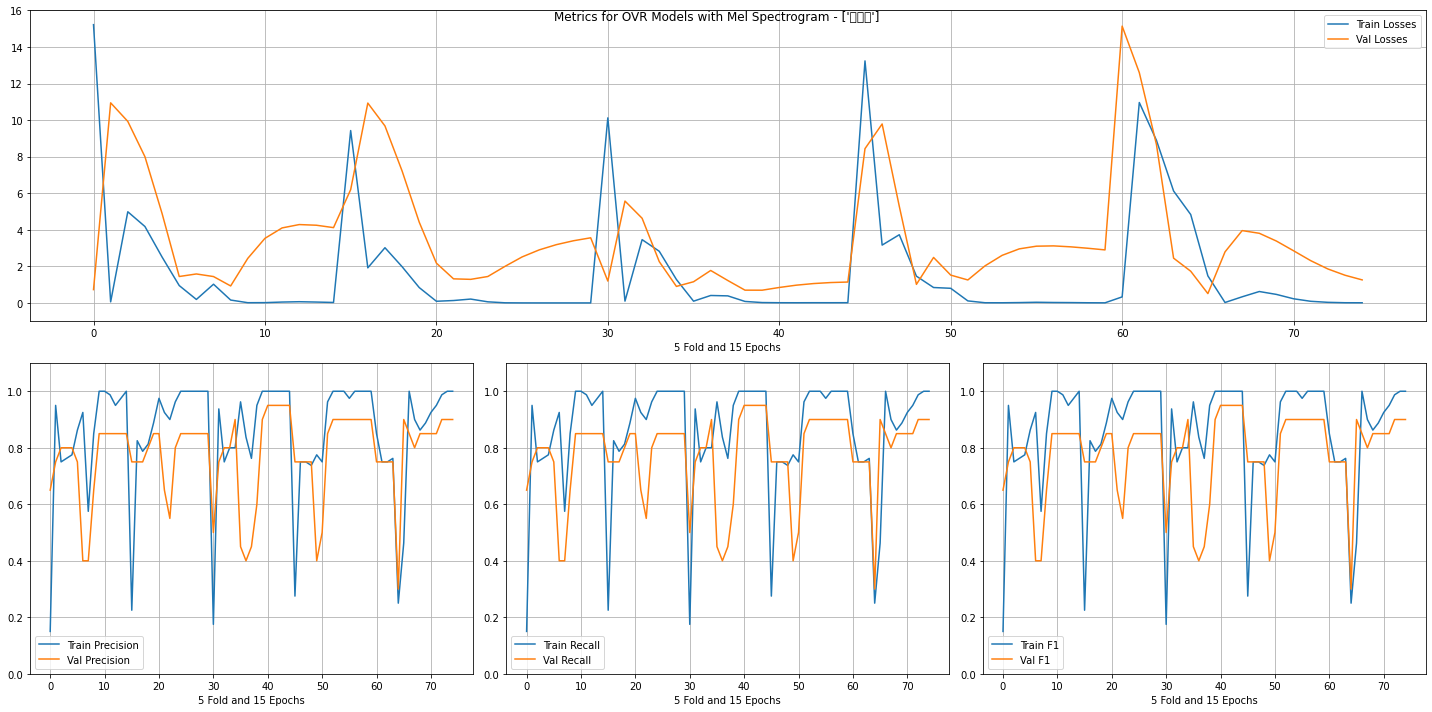

    train_f1  validation_f1  ...  train_losses  validation_losses
10    1.0000           0.95  ...      0.010851           0.844592
11    1.0000           0.95  ...      0.009493           0.971161
12    1.0000           0.95  ...      0.011705           1.058799
13    1.0000           0.95  ...      0.011184           1.114109
14    1.0000           0.95  ...      0.012564           1.141926
..       ...            ...  ...           ...                ...
4     0.7750           0.40  ...      0.842266           2.486966
6     0.8375           0.40  ...      0.406585           1.774588
7     0.5750           0.40  ...      1.023188           1.441940
6     0.9250           0.40  ...      0.189903           1.583791
4     0.2500           0.30  ...      4.833507           1.732798

[75 rows x 8 columns]
Training for ['నాదరామక్రియ'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 35/9
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 0.623 / Validation Loss

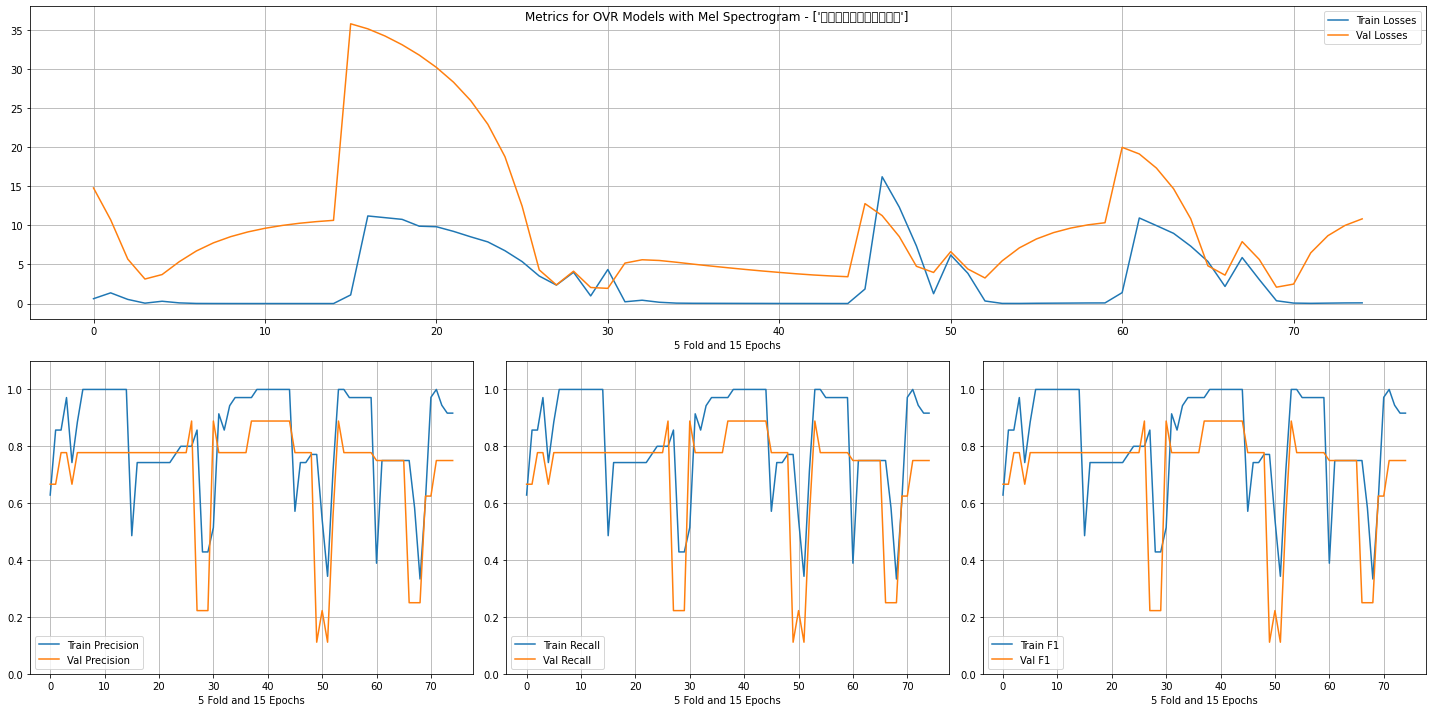

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.971429       0.888889  ...      0.026079           4.579858
14  1.000000       0.888889  ...      0.006630           3.431904
0   0.514286       0.888889  ...      4.351953           1.942833
8   1.000000       0.888889  ...      0.021159           4.367304
9   1.000000       0.888889  ...      0.018571           4.167053
..       ...            ...  ...           ...                ...
14  0.428571       0.222222  ...      0.978395           2.054152
13  0.428571       0.222222  ...      4.001697           4.137776
12  0.857143       0.222222  ...      2.362580           2.384304
6   0.342857       0.111111  ...      3.870972           4.418462
4   0.771429       0.111111  ...      1.261983           3.978801

[75 rows x 8 columns]
Training for ['పాడి'] with 49 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 156/40
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 10.280 / Validation Loss : 5

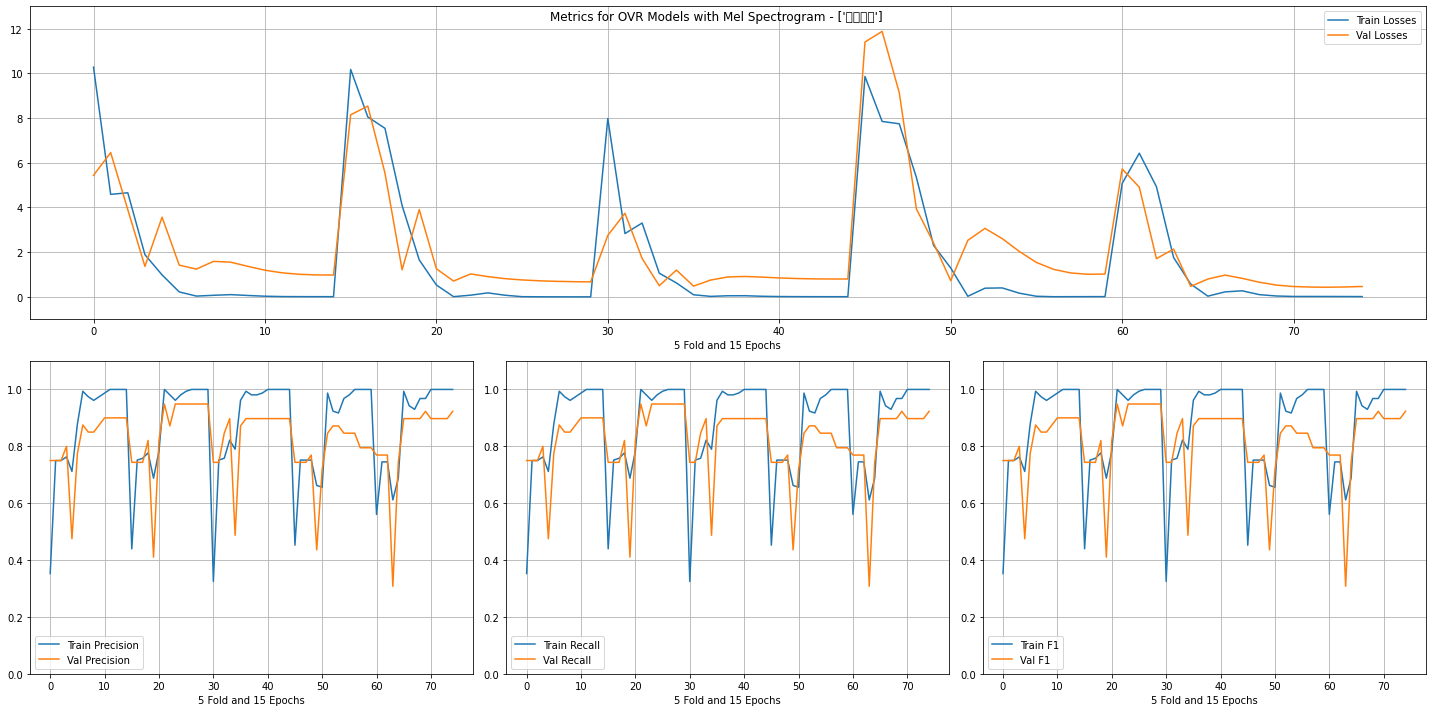

    train_f1  validation_f1  ...  train_losses  validation_losses
9   0.980892       0.948718  ...      0.072415           0.814693
10  0.993631       0.948718  ...      0.008685           0.757094
6   1.000000       0.948718  ...      0.009457           0.706643
14  1.000000       0.948718  ...      0.000812           0.669179
13  1.000000       0.948718  ...      0.001015           0.678997
..       ...            ...  ...           ...                ...
4   0.789809       0.487179  ...      0.623695           1.198358
4   0.711538       0.475000  ...      0.982198           3.567863
4   0.662420       0.435897  ...      2.306137           2.415011
4   0.687898       0.410256  ...      1.654777           3.906429
3   0.611465       0.307692  ...      1.762211           2.139127

[75 rows x 8 columns]
Training for ['బౌళి'] with 70 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 224/56
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 12.688 / Validation Loss : 9

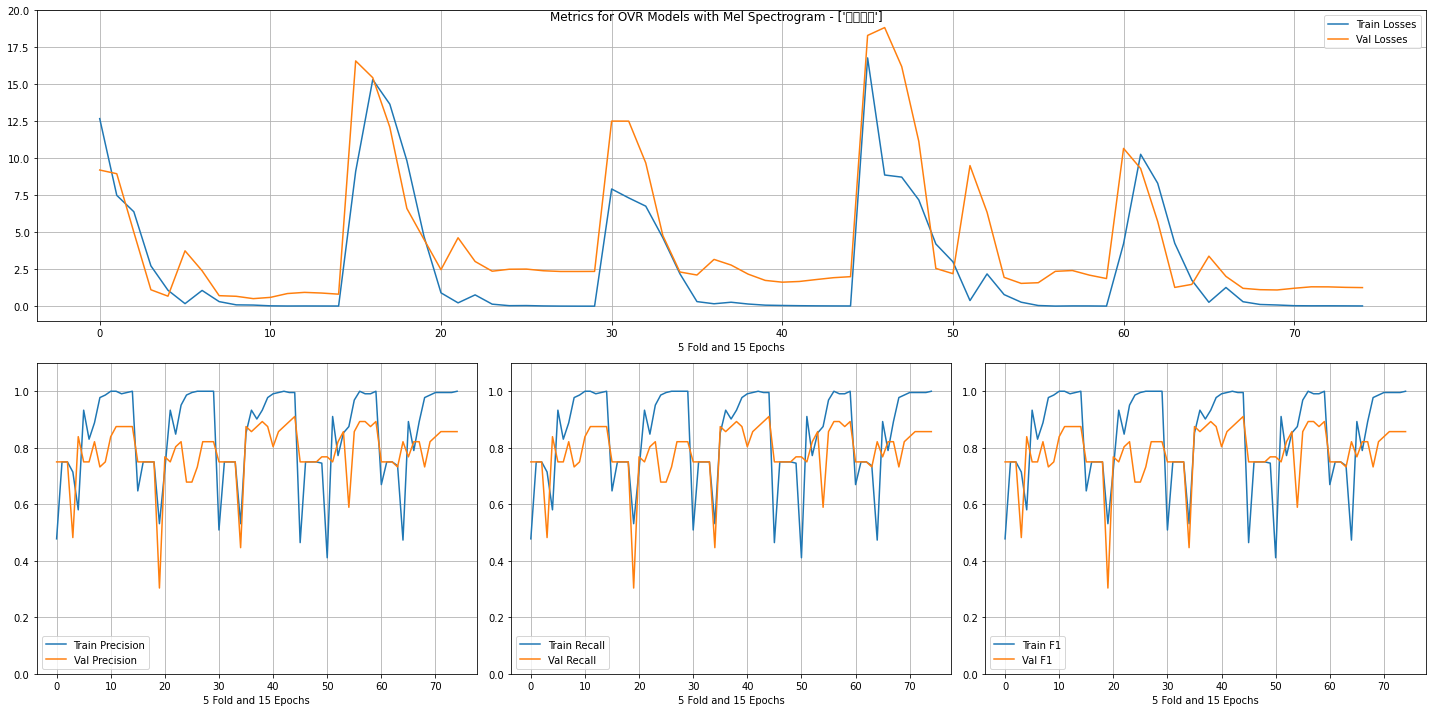

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.995536       0.910714  ...      0.028979           2.009104
8   0.933036       0.892857  ...      0.160316           2.179594
14  1.000000       0.892857  ...      0.020378           1.882381
13  0.995536       0.892857  ...      0.032180           1.939435
12  0.991071       0.892857  ...      0.033773           2.423656
..       ...            ...  ...           ...                ...
10  0.995536       0.678571  ...      0.056245           2.521391
9   0.875000       0.589286  ...      0.283819           1.554743
3   0.714286       0.482143  ...      2.738503           1.123701
4   0.531250       0.446429  ...      2.208752           2.324784
4   0.531250       0.303571  ...      4.746825           4.537356

[75 rows x 8 columns]
Training for ['బౌళిరామక్రియ'] with 13 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 41/11
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 5.052 / Validation Lo

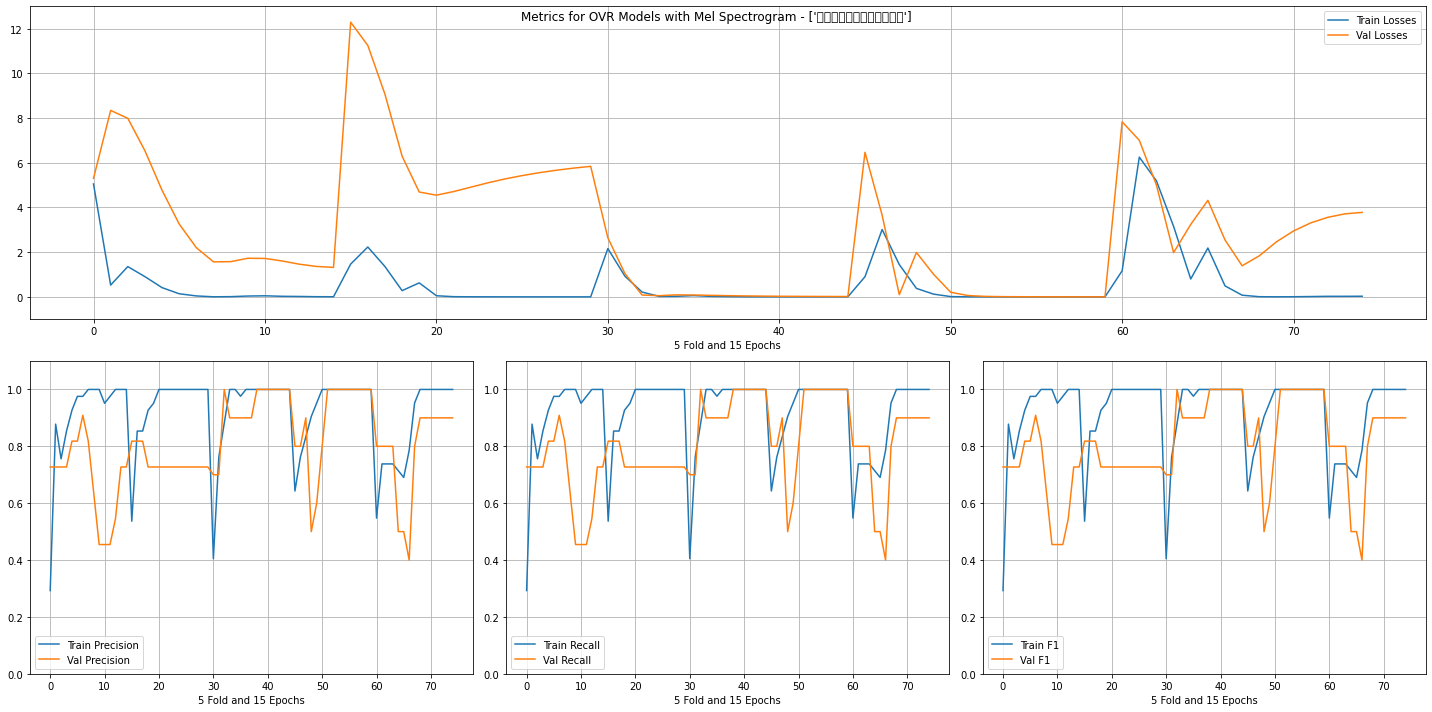

    train_f1  validation_f1  ...  train_losses  validation_losses
8   1.000000       1.000000  ...  5.097683e-05           0.009603
12  1.000000       1.000000  ...  9.631574e-07           0.001385
14  1.000000       1.000000  ...  2.663046e-04           0.014728
11  1.000000       1.000000  ...  7.984653e-04           0.022503
6   1.000000       1.000000  ...  1.267076e-03           0.059931
..       ...            ...  ...           ...                ...
3   0.904762       0.500000  ...  3.785890e-01           1.985361
9   1.000000       0.454545  ...  3.661422e-02           1.727050
10  0.951220       0.454545  ...  4.700220e-02           1.719943
11  0.975610       0.454545  ...  2.484423e-02           1.605901
6   0.785714       0.400000  ...  4.907868e-01           2.546295

[75 rows x 8 columns]
Training for ['భూపాలం'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 102/26
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 14.132 / Validation Loss :

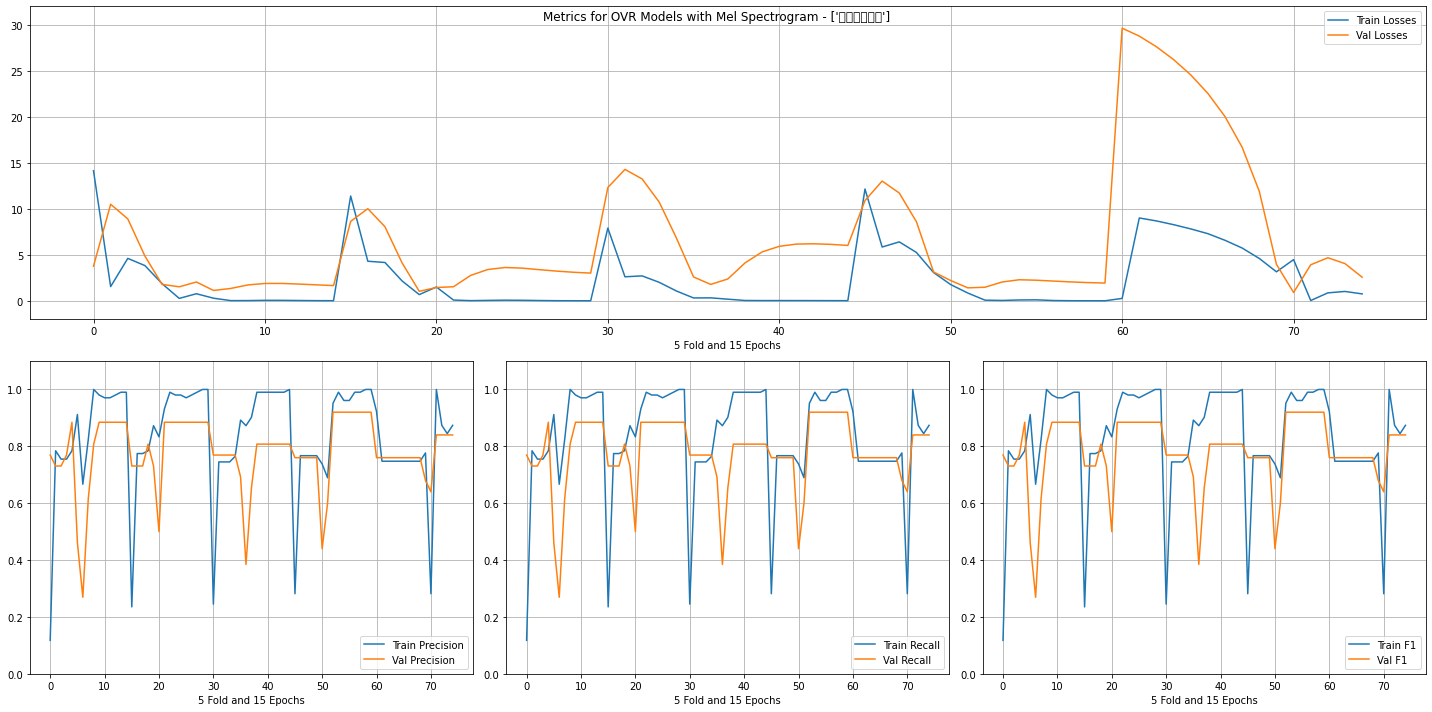

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.990291       0.920000  ...      0.030325           2.143398
7   0.951456       0.920000  ...      0.068939           1.473672
8   0.990291       0.920000  ...      0.040440           2.044537
14  1.000000       0.920000  ...      0.001518           1.930043
13  1.000000       0.920000  ...      0.004806           1.979284
..       ...            ...  ...           ...                ...
5   0.833333       0.500000  ...      1.499280           1.444068
5   0.911765       0.461538  ...      0.261698           1.521377
5   0.737864       0.440000  ...      1.761725           2.201159
6   0.872549       0.384615  ...      0.321146           1.781918
6   0.666667       0.269231  ...      0.767502           2.043607

[75 rows x 8 columns]
Training for ['భైరవి'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 86/22
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 15.552 / Validation Loss : 1

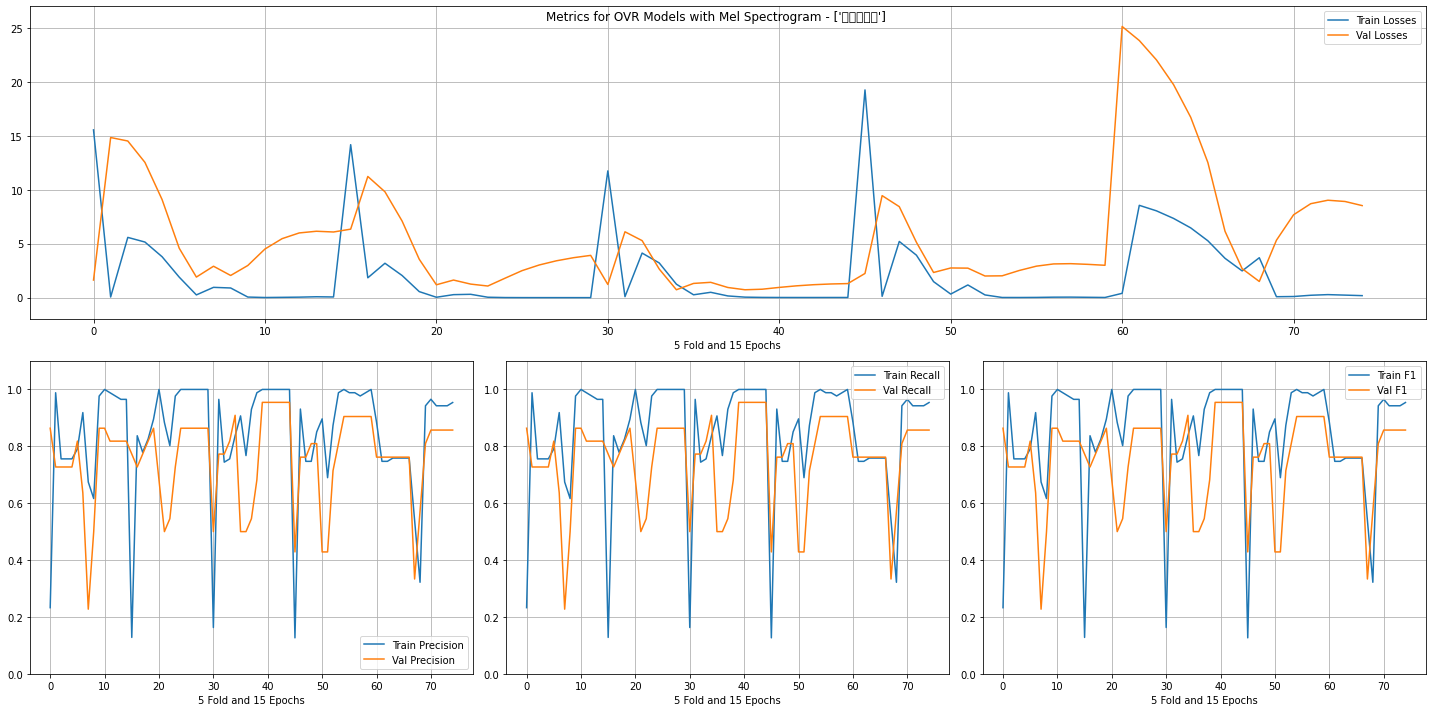

    train_f1  validation_f1  ...  train_losses  validation_losses
11  1.000000       0.954545  ...      0.012225           1.092381
10  1.000000       0.954545  ...      0.014157           0.947153
12  1.000000       0.954545  ...      0.011845           1.198071
13  1.000000       0.954545  ...      0.013462           1.265220
14  1.000000       0.954545  ...      0.013525           1.301811
..       ...            ...  ...           ...                ...
5   0.896552       0.428571  ...      0.328610           2.749035
0   0.126437       0.428571  ...     19.257196           2.240182
6   0.689655       0.428571  ...      1.175239           2.734050
7   0.540230       0.333333  ...      2.477366           2.684298
7   0.674419       0.227273  ...      0.952877           2.910750

[75 rows x 8 columns]
Training for ['మలహరి'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 64/16
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 12.192 / Validation Loss : 5

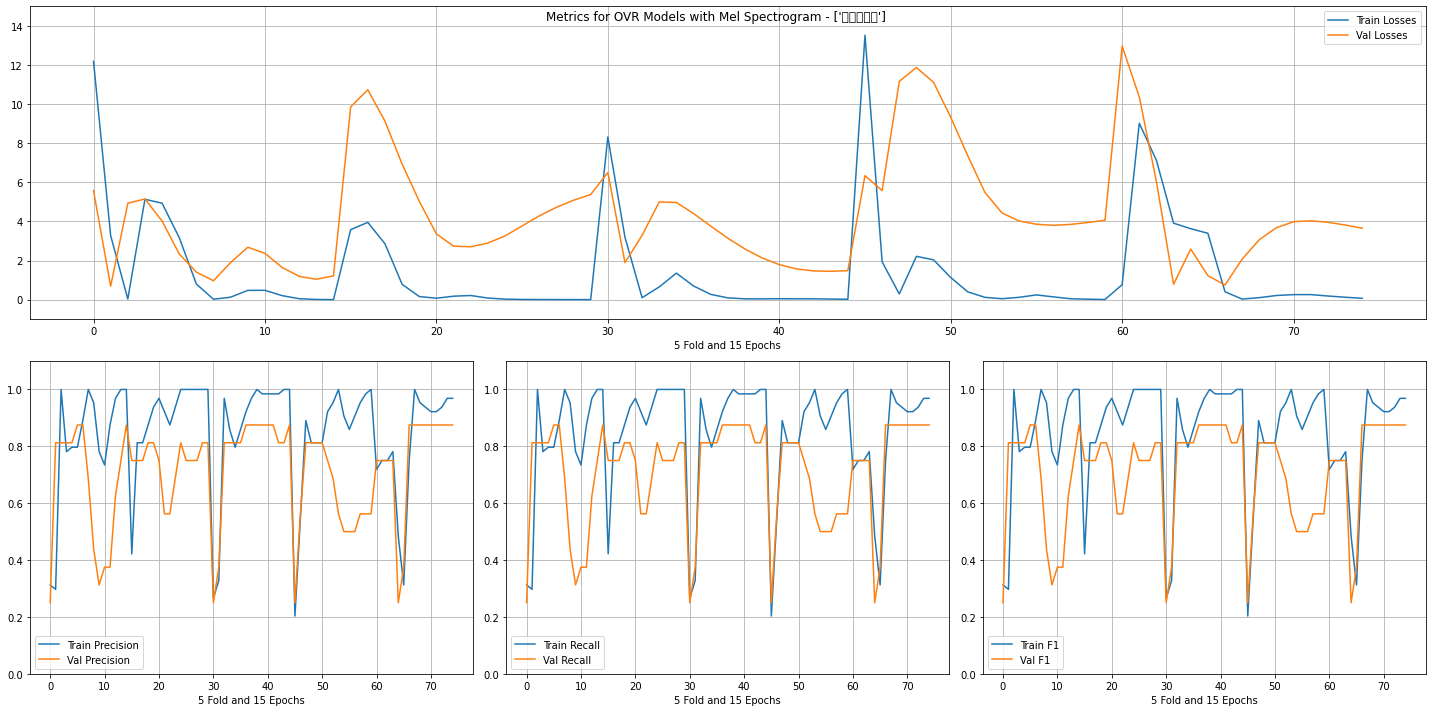

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.968750         0.8750  ...      0.090539           3.141317
6   0.921875         0.8750  ...      0.270399           3.762047
13  0.968750         0.8750  ...      0.123951           3.818000
12  0.937500         0.8750  ...      0.186543           3.959012
11  0.921875         0.8750  ...      0.258286           4.033307
..       ...            ...  ...           ...                ...
9   0.781250         0.3125  ...      0.473910           2.681671
0   0.203125         0.2500  ...     13.523540           6.345054
4   0.484375         0.2500  ...      3.628630           2.588050
0   0.265625         0.2500  ...      8.320821           6.500240
0   0.312500         0.2500  ...     12.191996           5.582581

[75 rows x 8 columns]
Training for ['మాళవి'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 57/15
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 7.299 / Validation Loss : 1.

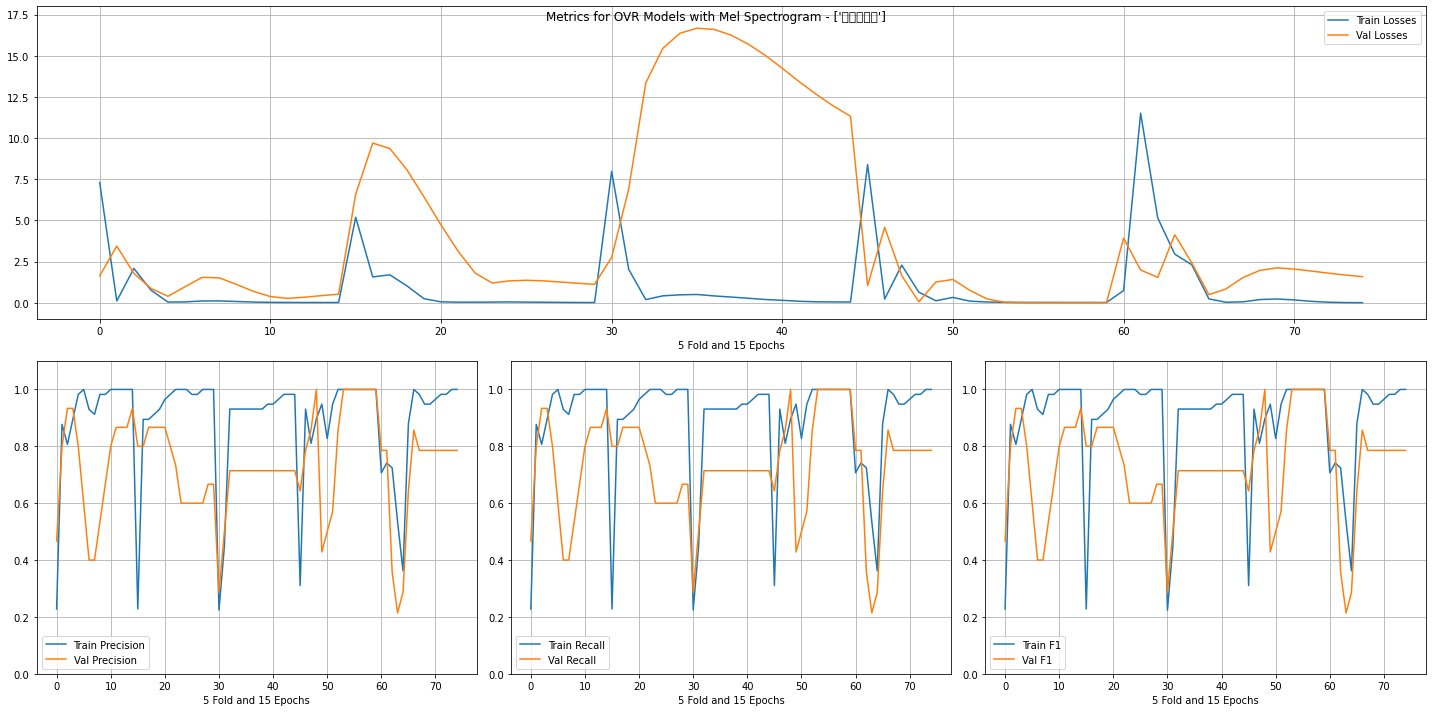

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       1.000000  ...      0.016933           0.001161
3   0.896552       1.000000  ...      0.641652           0.056464
12  1.000000       1.000000  ...      0.017527           0.001726
11  1.000000       1.000000  ...      0.019234           0.002891
10  1.000000       1.000000  ...      0.018481           0.005436
..       ...            ...  ...           ...                ...
6   0.929825       0.400000  ...      0.107986           1.540970
2   0.724138       0.357143  ...      5.158078           1.541050
4   0.362069       0.285714  ...      2.304971           2.414543
0   0.224138       0.285714  ...      7.976626           2.751254
3   0.534483       0.214286  ...      2.951259           4.129865

[75 rows x 8 columns]
Training for ['మాళవిగౌళ'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 57/15
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 9.074 / Validation Loss :

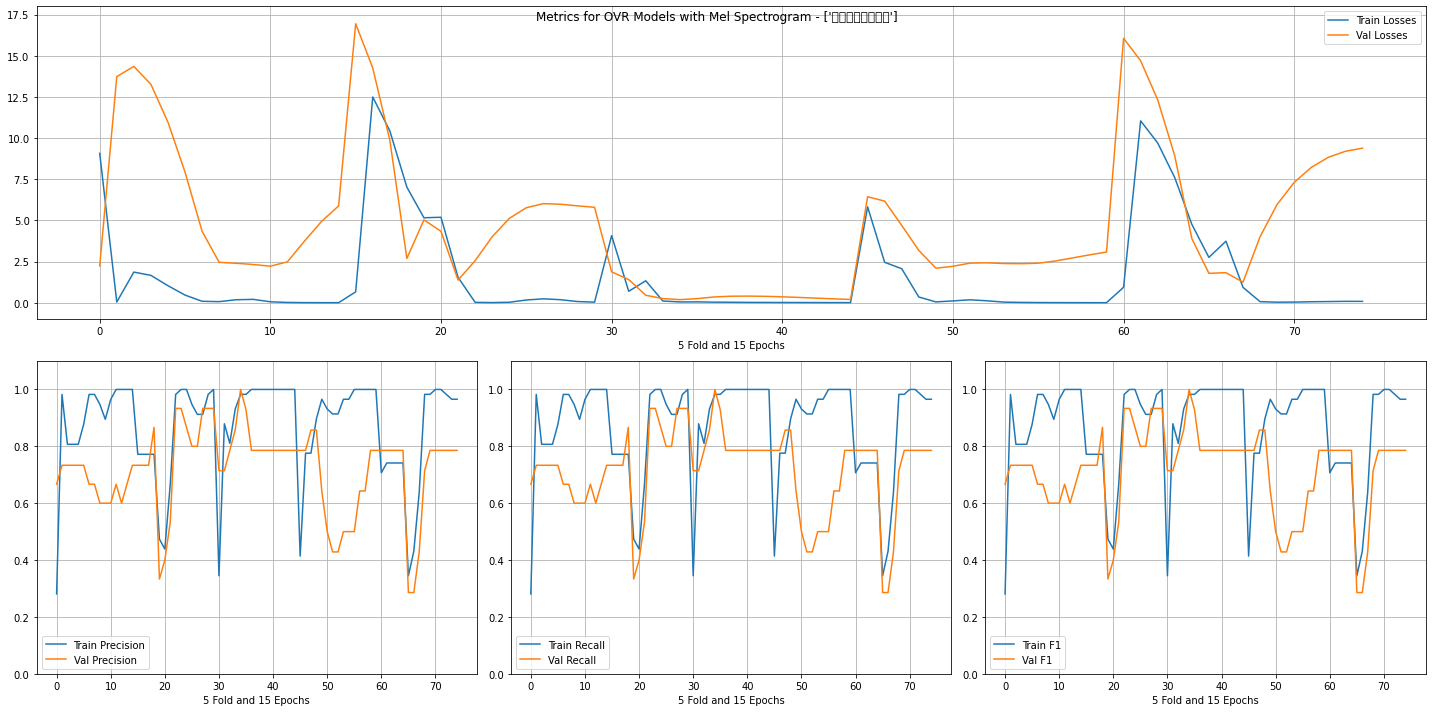

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.982759       1.000000  ...      0.047908           0.188714
7   0.982456       0.933333  ...      0.023478           2.555657
14  1.000000       0.933333  ...      0.035092           5.797251
13  0.982456       0.933333  ...      0.072812           5.884447
12  0.912281       0.933333  ...      0.184455           5.983618
..       ...            ...  ...           ...                ...
7   0.913793       0.428571  ...      0.117632           2.423643
5   0.438596       0.400000  ...      5.191733           4.339105
4   0.473684       0.333333  ...      5.161811           5.032854
6   0.431034       0.285714  ...      3.739151           1.826089
5   0.344828       0.285714  ...      2.753725           1.785975

[75 rows x 8 columns]
Training for ['ముఖారి'] with 55 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 176/44
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 9.145 / Validation Loss : 

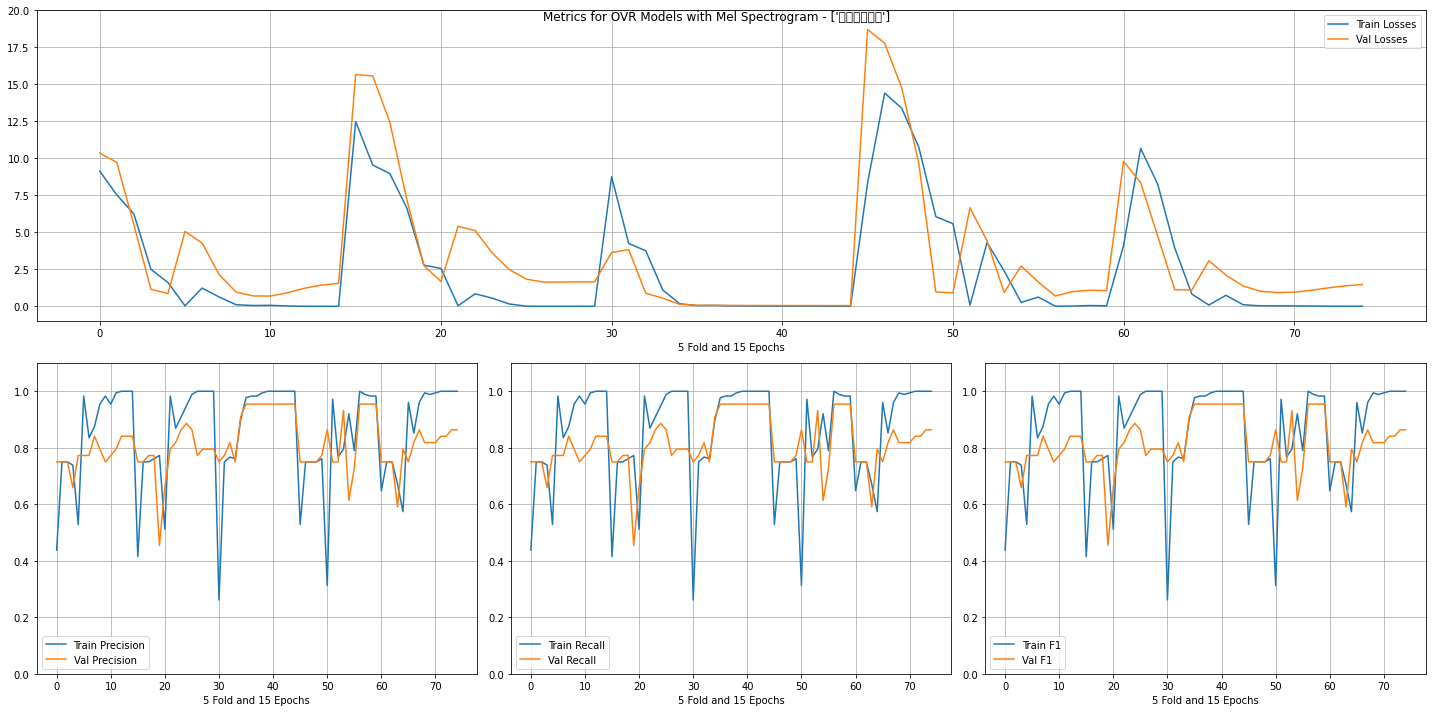

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.982955       0.954545  ...      0.042591           0.066764
14  1.000000       0.954545  ...      0.007947           0.056568
5   0.977273       0.954545  ...      0.059226           0.076843
6   0.982955       0.954545  ...      0.064745           0.072759
8   0.994318       0.954545  ...      0.025752           0.062232
..       ...            ...  ...           ...                ...
3   0.738636       0.659091  ...      2.509966           1.152775
5   0.511364       0.659091  ...      2.561579           1.682023
9   0.920455       0.613636  ...      0.267833           2.725090
3   0.670455       0.590909  ...      3.947652           1.130249
4   0.772727       0.454545  ...      2.788419           2.763332

[75 rows x 8 columns]
Training for ['రామక్రియ'] with 61 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 195/49
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 7.060 / Validation Loss 

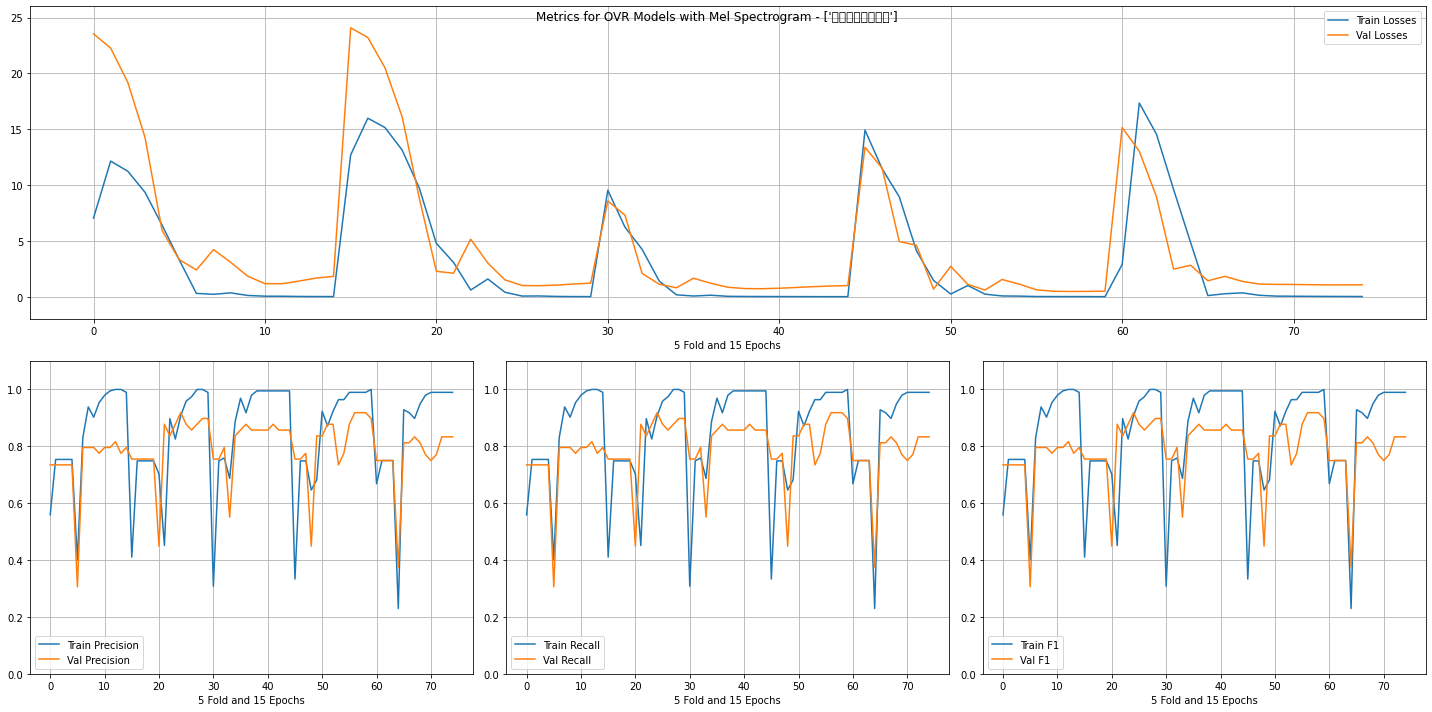

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.989744       0.918367  ...      0.022516           0.491267
12  0.989744       0.918367  ...      0.025324           0.479358
11  0.989744       0.918367  ...      0.025169           0.502777
9   0.907692       0.918367  ...      0.413000           1.518715
14  0.989744       0.897959  ...      0.022929           1.222377
..       ...            ...  ...           ...                ...
3   0.687179       0.551020  ...      1.410983           1.127052
3   0.646154       0.448980  ...      4.131320           4.620479
5   0.702564       0.448980  ...      4.785908           2.286505
4   0.229592       0.375000  ...      4.834745           2.828649
5   0.400000       0.306122  ...      3.316298           3.331193

[75 rows x 8 columns]
Training for ['లలిత'] with 98 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 313/79
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 11.895 / Validation Loss : 1

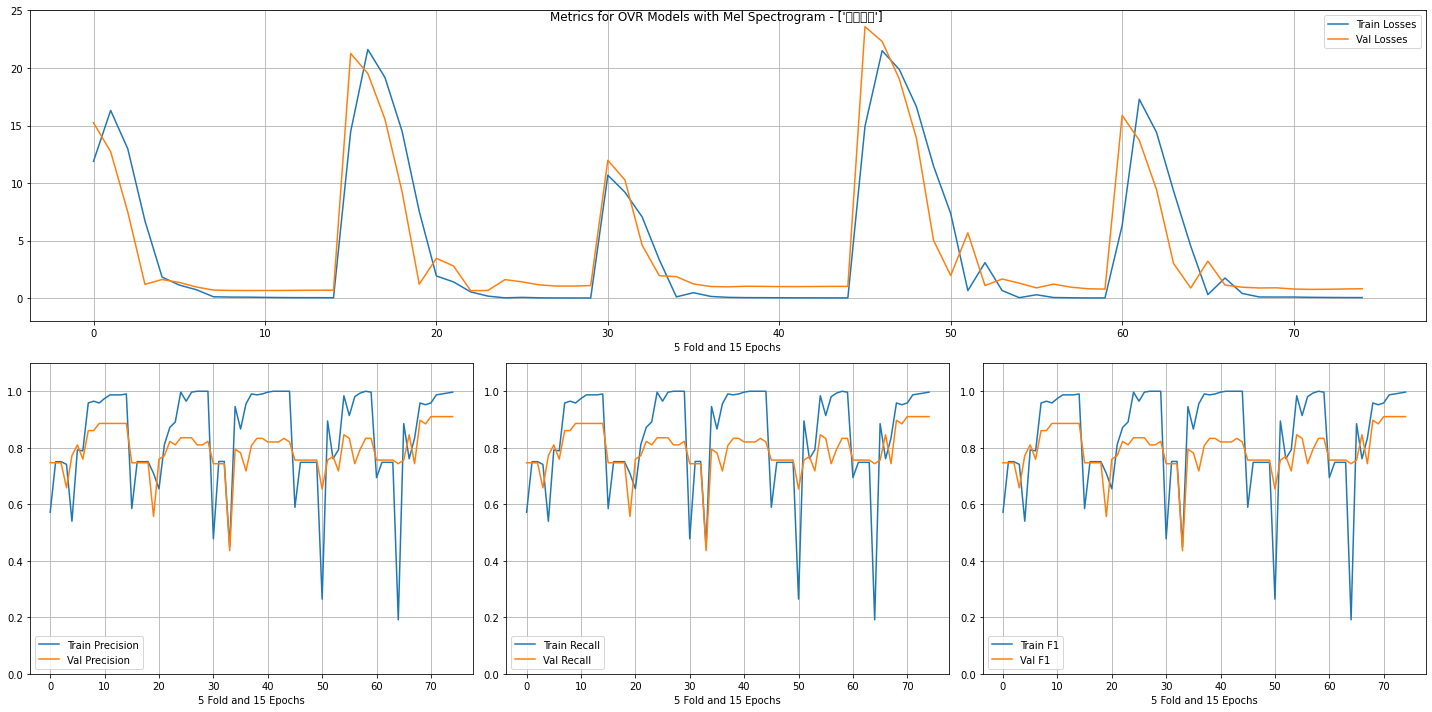

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.996815       0.910256  ...      0.050488           0.819162
13  0.993631       0.910256  ...      0.054887           0.800607
12  0.990446       0.910256  ...      0.063658           0.774475
11  0.987261       0.910256  ...      0.074881           0.762980
10  0.958599       0.910256  ...      0.099131           0.797350
..       ...            ...  ...           ...                ...
8   0.792994       0.717949  ...      0.661739           1.665304
3   0.741214       0.658228  ...      6.723881           1.203590
5   0.264331       0.653846  ...      7.352597           1.970296
4   0.709265       0.556962  ...      7.540774           1.212188
3   0.449045       0.435897  ...      3.348587           1.954325

[75 rows x 8 columns]
Training for ['వరాళి'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 70/18
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 8.528 / Validation Loss : 9.

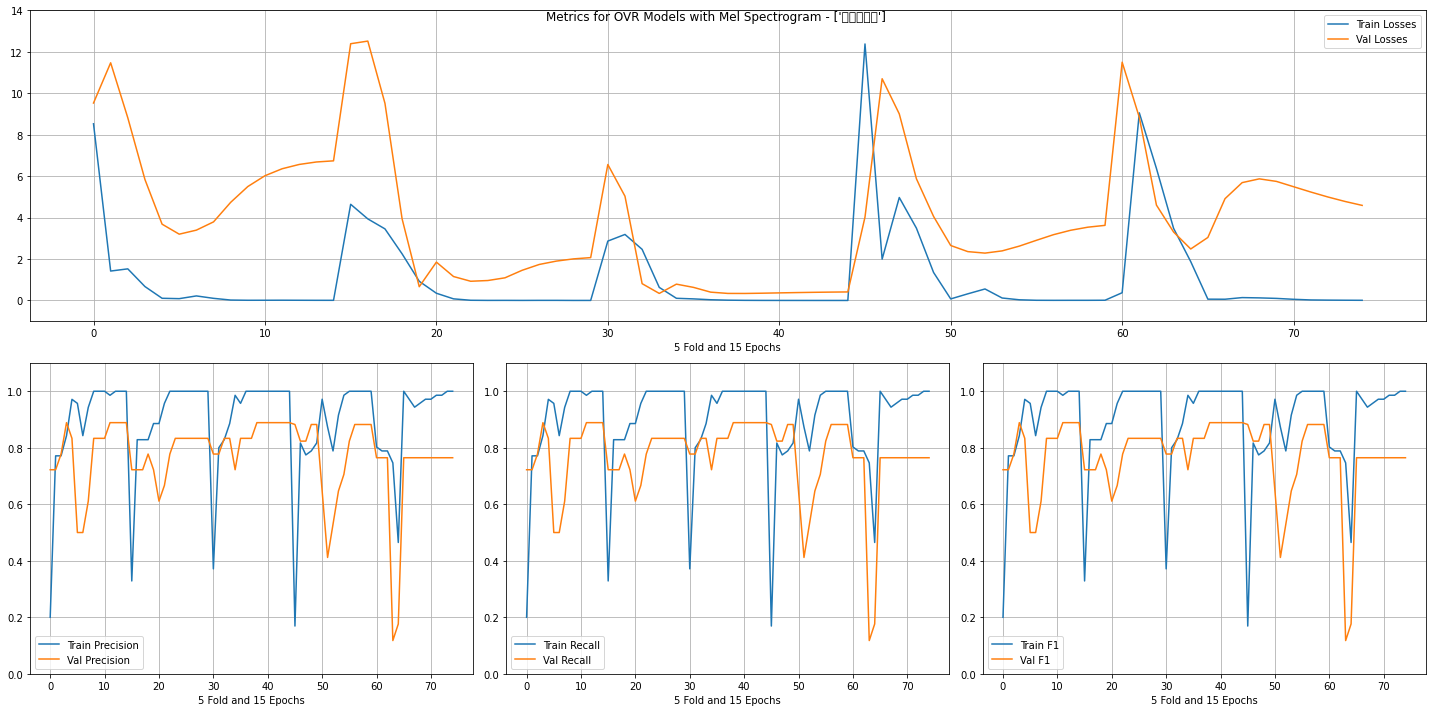

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       0.888889  ...      0.008248           6.684108
12  1.000000       0.888889  ...      0.010541           6.565344
8   1.000000       0.888889  ...      0.006820           0.339191
3   0.842857       0.888889  ...      0.672402           5.838797
9   1.000000       0.888889  ...      0.003703           0.351118
..       ...            ...  ...           ...                ...
6   0.842857       0.500000  ...      0.219888           3.395153
5   0.957143       0.500000  ...      0.088246           3.200119
6   0.873239       0.411765  ...      0.321835           2.357878
4   0.464789       0.176471  ...      1.875932           2.485630
3   0.746479       0.117647  ...      3.482153           3.304412

[75 rows x 8 columns]
Training for ['శంకరాభరణం'] with 68 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 217/55
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 12.867 / Validation Los

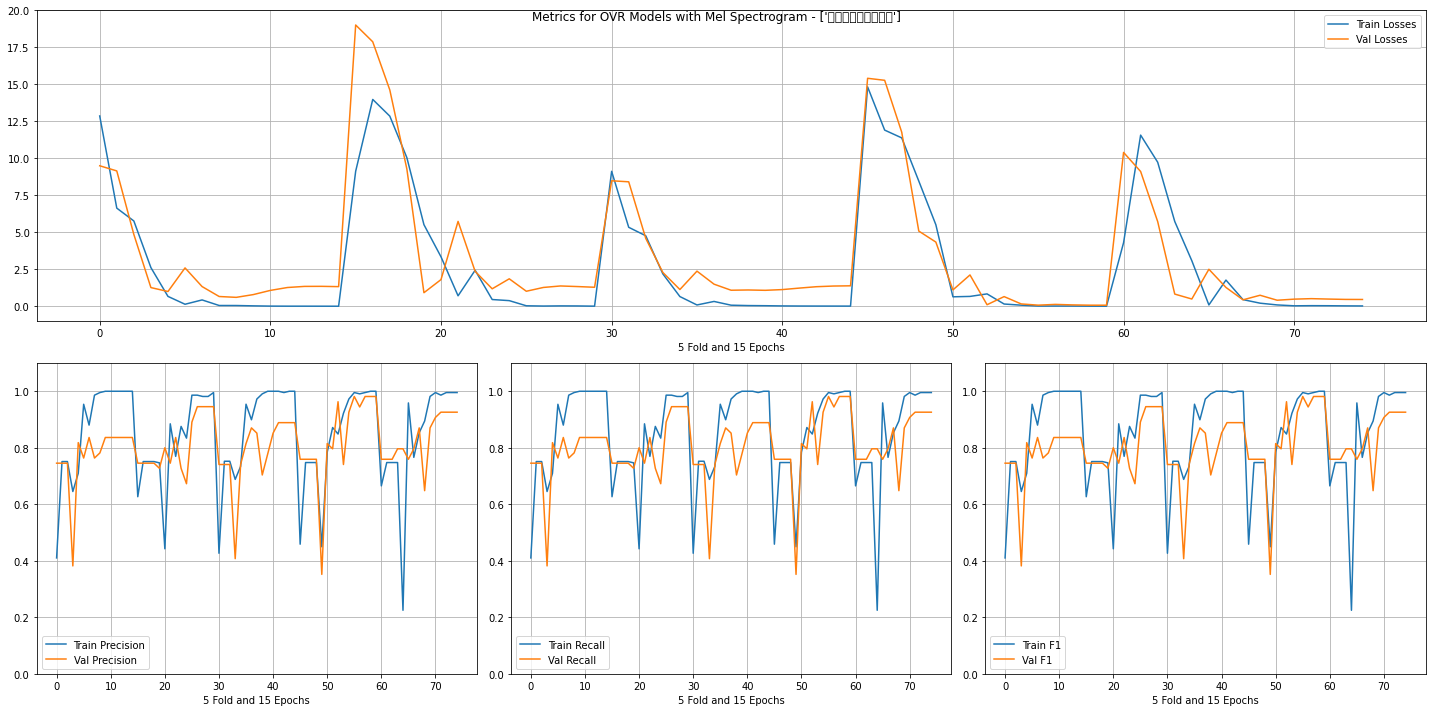

    train_f1  validation_f1  ...  train_losses  validation_losses
10  0.995413       0.981481  ...      0.024332           0.083976
14  1.000000       0.981481  ...      0.012644           0.080439
12  0.995413       0.981481  ...      0.024483           0.101425
13  1.000000       0.981481  ...      0.016460           0.082146
7   0.848624       0.962963  ...      0.844829           0.113002
..       ...            ...  ...           ...                ...
9   0.834101       0.672727  ...      0.389735           1.864129
8   0.894495       0.648148  ...      0.217693           0.753408
3   0.688073       0.407407  ...      2.198687           2.294442
3   0.645161       0.381818  ...      2.621482           1.271641
4   0.449541       0.351852  ...      5.517291           4.345889

[75 rows x 8 columns]
Training for ['శుద్ధవసంతం'] with 33 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 105/27
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 14.954 / Validation Lo

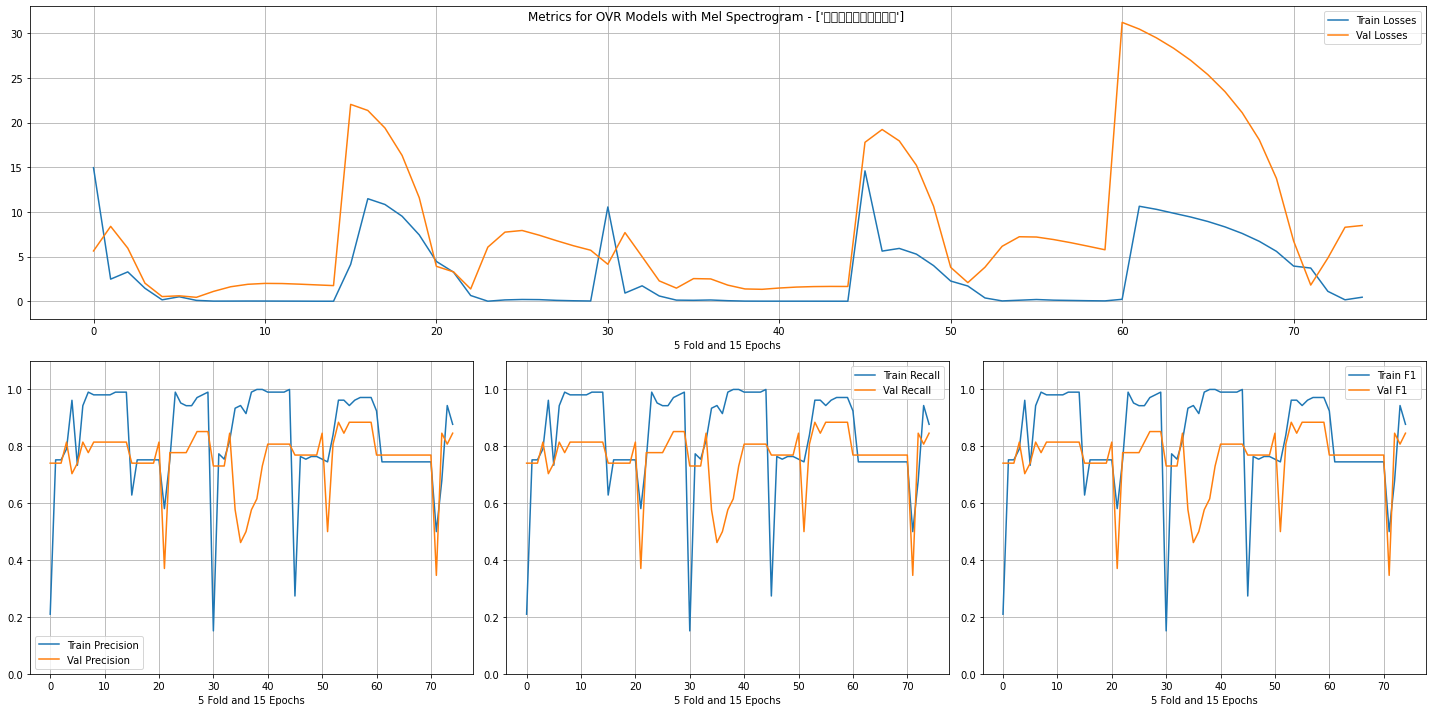

    train_f1  validation_f1  ...  train_losses  validation_losses
10  0.943396       0.884615  ...      0.202502           7.194801
11  0.962264       0.884615  ...      0.129954           6.912728
12  0.971698       0.884615  ...      0.099183           6.562557
13  0.971698       0.884615  ...      0.068591           6.170739
14  0.971698       0.884615  ...      0.050561           5.767611
..       ...            ...  ...           ...                ...
6   0.745283       0.500000  ...      1.711181           2.091215
6   0.915094       0.500000  ...      0.149386           2.507770
5   0.943396       0.461538  ...      0.115013           2.542189
6   0.580952       0.370370  ...      3.262491           3.295614
11  0.500000       0.346154  ...      3.723200           1.821479

[75 rows x 8 columns]
Training for ['శ్రీరాగం'] with 65 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 208/52
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 10.197 / Validation Loss

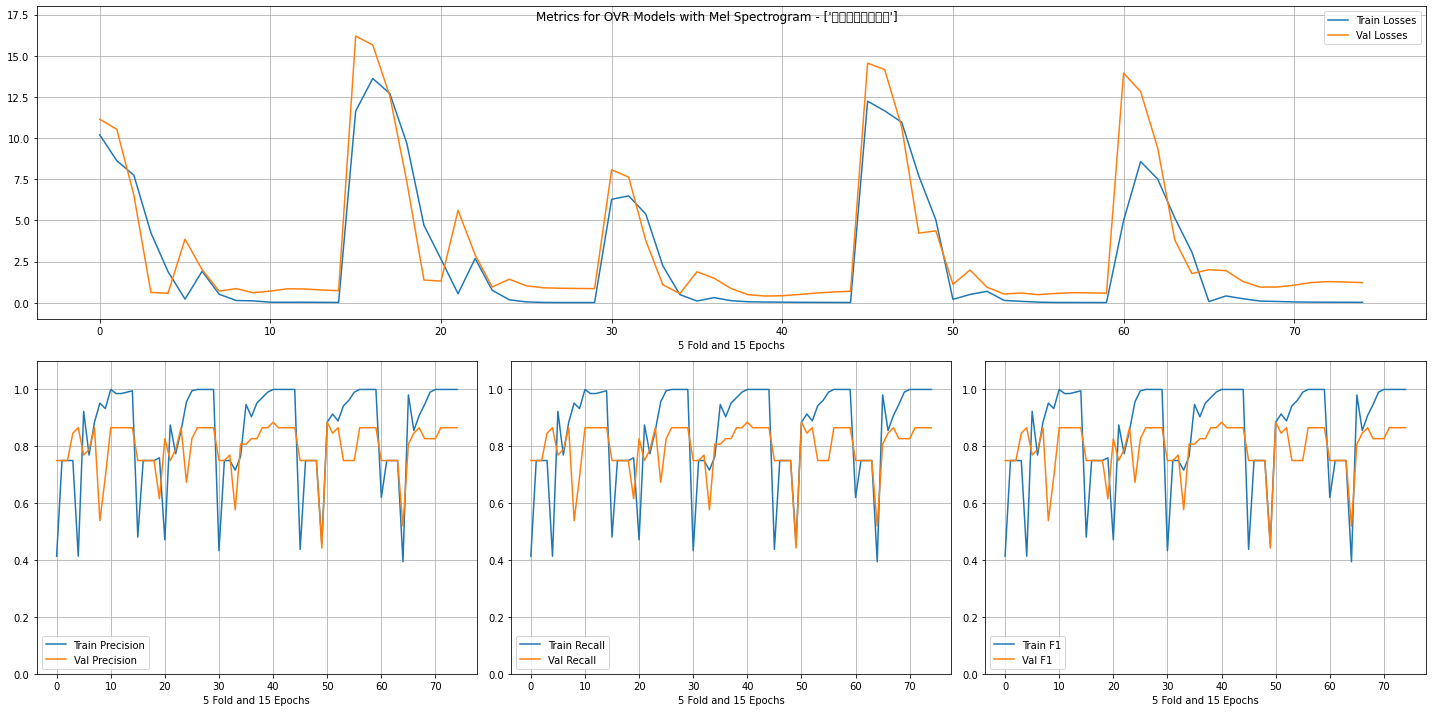

    train_f1  validation_f1  ...  train_losses  validation_losses
10  1.000000       0.884615  ...      0.035156           0.426216
5   0.884615       0.884615  ...      0.203865           1.117305
14  1.000000       0.865385  ...      0.025806           1.222763
12  1.000000       0.865385  ...      0.012986           0.878015
12  1.000000       0.865385  ...      0.015983           0.610410
..       ...            ...  ...           ...                ...
4   0.759615       0.615385  ...      4.710252           1.381021
3   0.716346       0.576923  ...      2.241938           1.092985
8   0.951923       0.538462  ...      0.135144           0.858382
4   0.394231       0.519231  ...      3.085073           1.771330
4   0.456731       0.442308  ...      5.028232           4.367034

[75 rows x 8 columns]
Training for ['సామంతం'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 284/72
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 11.058 / Validation Loss :

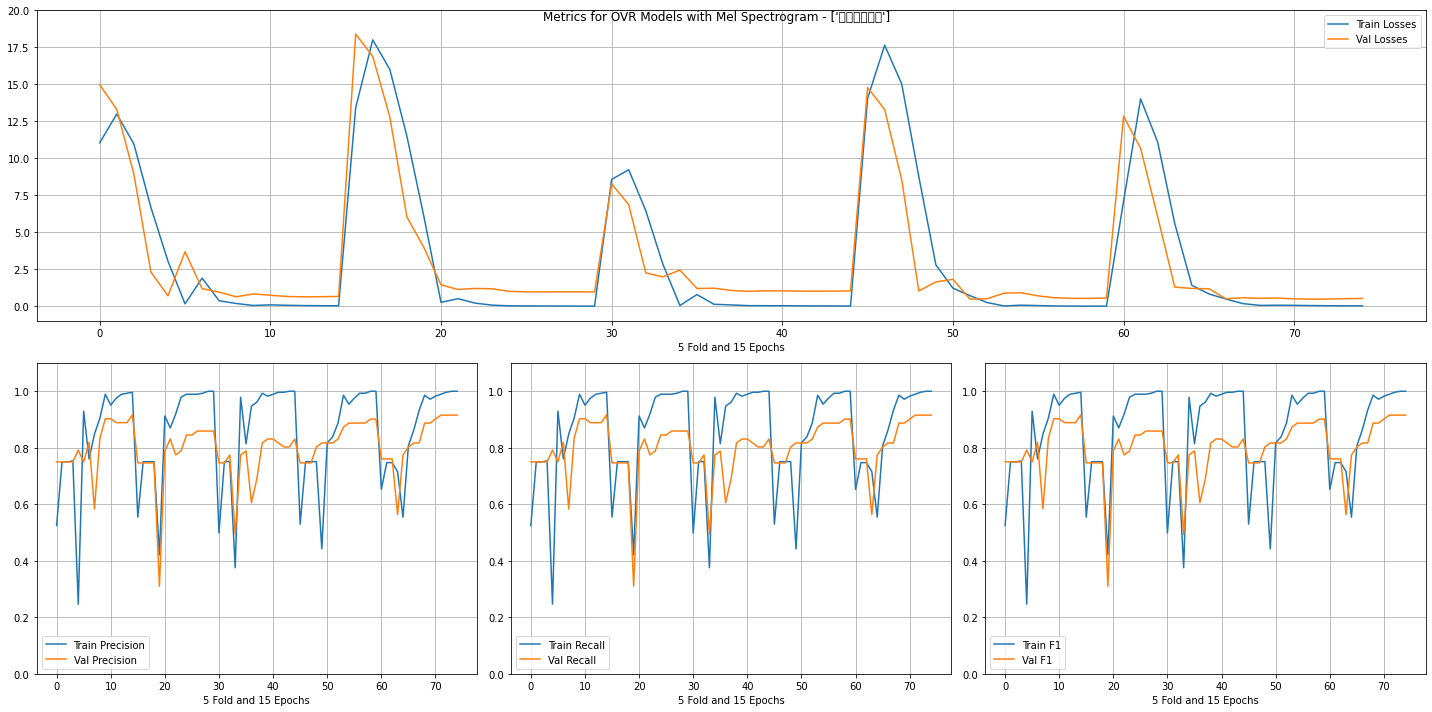

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.996479       0.916667  ...      0.040875           0.676660
14  1.000000       0.915493  ...      0.036654           0.538207
13  1.000000       0.915493  ...      0.040023           0.521744
12  0.996491       0.915493  ...      0.045838           0.496443
11  0.989474       0.915493  ...      0.055734           0.486271
..       ...            ...  ...           ...                ...
6   0.947368       0.605634  ...      0.143732           1.228654
7   0.848592       0.583333  ...      0.381505           0.962164
3   0.715789       0.563380  ...      5.602630           1.304563
3   0.375439       0.492958  ...      2.858878           1.992723
4   0.421053       0.309859  ...      6.056019           3.967786

[75 rows x 8 columns]
Training for ['సాళంగం'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 35/9
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 4.699 / Validation Loss : 3.

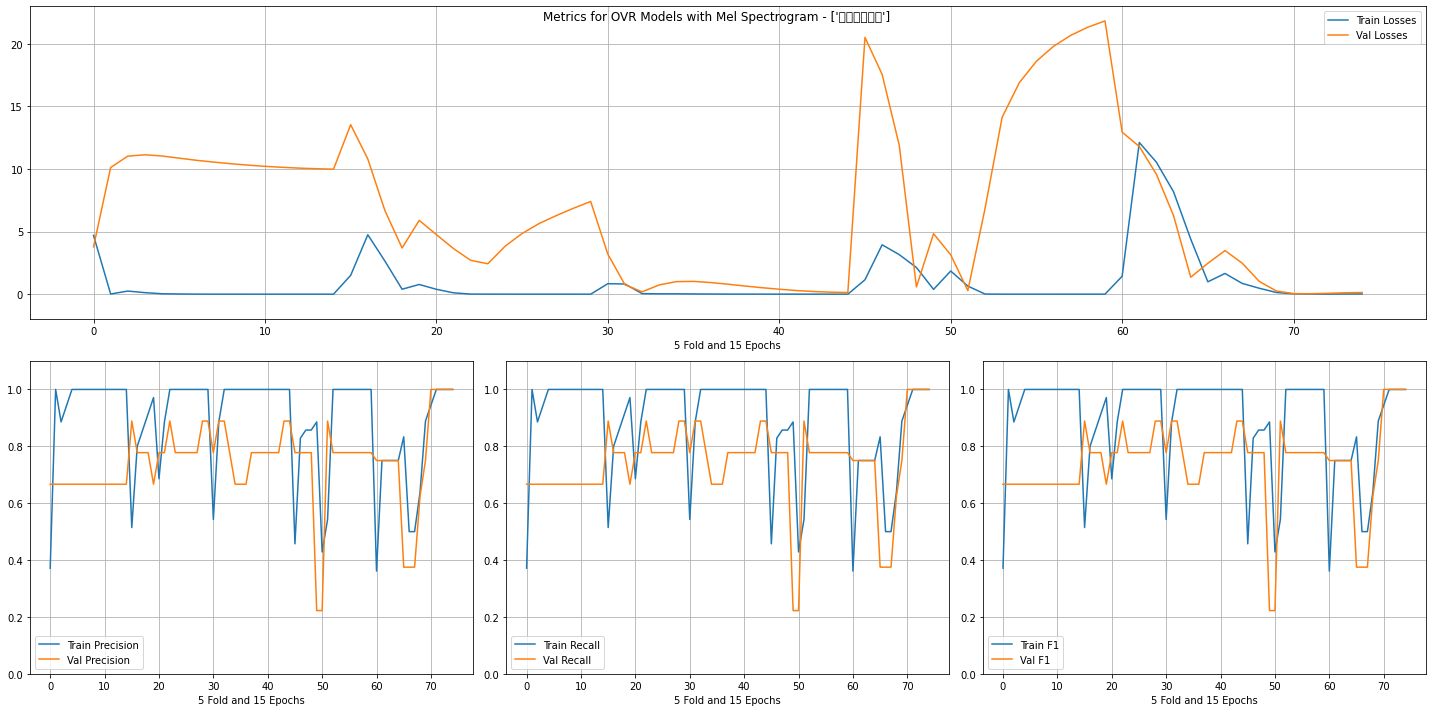

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       1.000000  ...      0.016759           0.135833
13  1.000000       1.000000  ...      0.012214           0.111382
12  1.000000       1.000000  ...      0.008454           0.068902
11  1.000000       1.000000  ...      0.010914           0.034307
10  0.944444       1.000000  ...      0.031795           0.042770
..       ...            ...  ...           ...                ...
5   0.833333       0.375000  ...      0.988694           2.468153
7   0.500000       0.375000  ...      0.861469           2.482028
6   0.500000       0.375000  ...      1.655276           3.484179
5   0.428571       0.222222  ...      1.849712           3.145233
4   0.885714       0.222222  ...      0.383668           4.834533

[75 rows x 8 columns]
Training for ['సాళంగనాట'] with 94 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 300/76
Class Weights : [0.66666667 2.        ]
Epoch 1/15 : Training Loss: 11.292 / Validation Loss

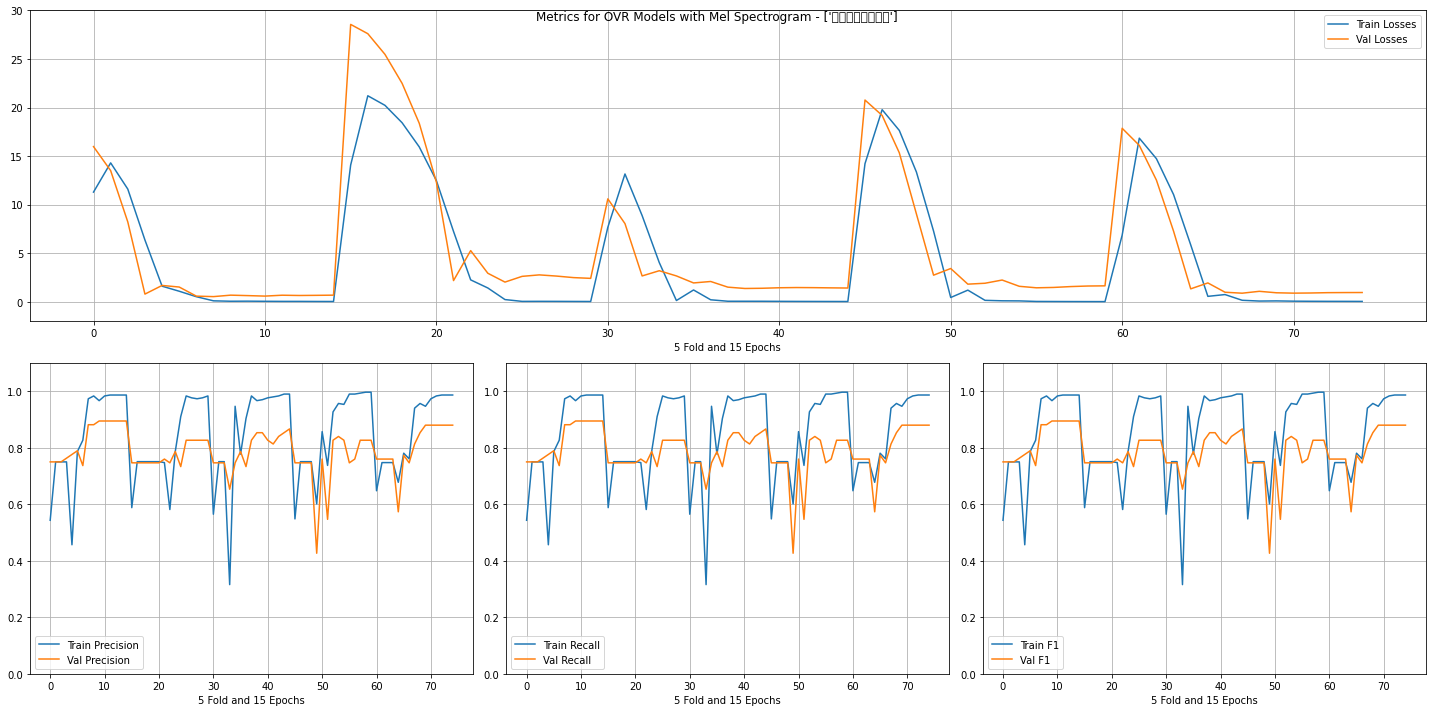

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.986667       0.894737  ...      0.029456           0.681760
13  0.986667       0.894737  ...      0.032590           0.662872
12  0.986667       0.894737  ...      0.040014           0.648223
11  0.986667       0.894737  ...      0.040640           0.675312
10  0.983333       0.894737  ...      0.049403           0.584288
..       ...            ...  ...           ...                ...
6   0.903654       0.733333  ...      0.203988           2.088788
3   0.315615       0.653333  ...      4.036890           3.196349
4   0.677741       0.573333  ...      5.853014           1.330616
6   0.737542       0.546667  ...      1.198895           1.814245
4   0.601329       0.426667  ...      7.277074           2.739177

[75 rows x 8 columns]


In [71]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data['Ragam'])
labels = le.transform(le.classes_)
ovr_res = ovr_train_model(data, MelMatrixDataset, MelRaga, "OVR Models with Mel Spectrogram", 
                          labels, le.classes_, lbl_encoder=le, lr=1e-5, epochs=15, n_folds=5, feature='mel_spec')